# Telecom Churn Case Study 

- In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.
- For many incumbent operators, retaining high profitable customers is the number one business goal.
- To reduce customer churn, telecom companies need to predict which customers are at high risk of churn.

In this project, we will analyse customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn and identify the main indicators of churn.

In [1]:
# Importing required libraries and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
# Importing classification report and confusion matrix from sklearn metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#### Reading dataset

In [2]:
# read dataset
telecom_df = pd.read_csv('./telecom_churn_data.csv')

In [3]:
# Inspecting data
telecom_df.info()
telecom_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


In [4]:
# checking for missing values %age
round(100*(telecom_df.isnull().sum()/len(telecom_df.index)), 2)

mobile_number     0.00
circle_id         0.00
loc_og_t2o_mou    1.02
std_og_t2o_mou    1.02
loc_ic_t2o_mou    1.02
                  ... 
aon               0.00
aug_vbc_3g        0.00
jul_vbc_3g        0.00
jun_vbc_3g        0.00
sep_vbc_3g        0.00
Length: 226, dtype: float64

### Filter High Value Customers
- Scoping our sample to the High valued customer (top 30%) who demonstrated high spending in the initial two months.
- Churn Indicator created based on the provided business logics

In [5]:
# create Churn data

telecom_df1 = telecom_df
telecom_df1['total_rech_amt_good_phase'] = (telecom_df1['total_rech_amt_6'] + telecom_df1['total_rech_amt_7'])/2
telecom_df1 = telecom_df1[telecom_df1['total_rech_amt_good_phase'] > telecom_df1['total_rech_amt_good_phase'].quantile(0.70)]

telecom_df1['total_usage_col'] = telecom_df1['total_og_mou_9'] + telecom_df1['total_ic_mou_9'] + telecom_df1['vol_2g_mb_9'] + telecom_df1['vol_3g_mb_9']

telecom_df1['churn'] = np.where(telecom_df1['total_usage_col']== 0, 1, 0)
telecom_df1['churn'].value_counts()

C:\Users\hp\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\hp\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


0    27390
1     2589
Name: churn, dtype: int64

In [6]:
telecom_df1 = telecom_df1.drop(['total_rech_amt_good_phase','total_usage_col'],1)

As per the analysis scope dropping all the variables of the 9th month after the churn indicator creation

In [7]:
nine_col = [col for col in telecom_df1.columns if '_9' in col]
print(telecom_df1.shape)
telecom_df1 = telecom_df1.drop(nine_col, axis = 1)
print(telecom_df1.shape)
telecom_df1 = telecom_df1.drop('sep_vbc_3g', axis=1)

(29979, 227)
(29979, 173)


### Checking Churn rate

In [8]:
y = telecom_df1['churn']
churn = (sum(y)/len(y.index))*100
print(churn)
print(telecom_df1.shape)

## Churn rate is 8.63.

8.636045231662164
(29979, 172)


In [9]:
# Describing dataset to get insights
telecom_df1.describe()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn
count,2.997900e+04,29979.0,29865.0,29865.0,29865.0,29979.000000,29979.000000,29979.000000,29663.000000,29676.000000,...,29979.000000,29979.000000,11387.000000,11652.000000,11741.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.00000
mean,7.001223e+09,109.0,0.0,0.0,0.0,587.587624,589.424681,535.067748,299.392147,307.701888,...,0.150339,0.140498,0.897603,0.889804,0.837322,1264.158911,129.482436,135.225368,121.450911,0.08636
std,6.846594e+05,0.0,0.0,0.0,0.0,442.848876,463.049067,492.447887,462.369385,483.432401,...,0.969779,0.975212,0.303184,0.313147,0.369087,975.181038,390.625027,408.218570,389.910814,0.28090
min,7.000000e+09,109.0,0.0,0.0,0.0,-2258.709000,-2014.045000,-945.808000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000,0.000000,0.000000,0.00000
25%,7.000641e+09,109.0,0.0,0.0,0.0,364.352500,365.235000,289.782000,43.030000,42.775000,...,0.000000,0.000000,1.000000,1.000000,1.000000,480.000000,0.000000,0.000000,0.000000,0.00000
50%,7.001232e+09,109.0,0.0,0.0,0.0,495.951000,493.781000,452.232000,128.480000,128.120000,...,0.000000,0.000000,1.000000,1.000000,1.000000,914.000000,0.000000,0.000000,0.000000,0.00000
75%,7.001814e+09,109.0,0.0,0.0,0.0,704.184500,700.986000,671.349500,357.655000,365.127500,...,0.000000,0.000000,1.000000,1.000000,1.000000,1923.500000,1.600000,2.025000,0.000000,0.00000
max,7.002411e+09,109.0,0.0,0.0,0.0,27731.088000,35145.834000,33543.624000,7376.710000,8157.780000,...,35.000000,41.000000,1.000000,1.000000,1.000000,4321.000000,12916.220000,9165.600000,11166.210000,1.00000


In [10]:
# checking percentage missing values
round(100*(telecom_df1.isnull().sum()/len(telecom_df1.index)), 2)

mobile_number     0.00
circle_id         0.00
loc_og_t2o_mou    0.38
std_og_t2o_mou    0.38
loc_ic_t2o_mou    0.38
                  ... 
aon               0.00
aug_vbc_3g        0.00
jul_vbc_3g        0.00
jun_vbc_3g        0.00
churn             0.00
Length: 172, dtype: float64

#### Dropping colums with only one unique value 
- These columns are showing zero variance

In [11]:
#delete coloum as all value are zero or constant
telecom_df2 = telecom_df1.drop(['circle_id','loc_og_t2o_mou','std_og_t2o_mou','loc_ic_t2o_mou','std_og_t2c_mou_6',
                     'std_og_t2c_mou_7','std_og_t2c_mou_8','std_ic_t2o_mou_6','std_ic_t2o_mou_7',
                   'std_ic_t2o_mou_8','last_date_of_month_6','last_date_of_month_7','last_date_of_month_8'], 1)

In [12]:
#Droping colum
fields_to_be_imputed_with_2 = ['fb_user','night_pck_user','arpu_2g','arpu_3g','av_rech_amt_data','count_rech_3g',
'count_rech_2g','max_rech_data','total_rech_data','date_of_last_rech_data']

for field in fields_to_be_imputed_with_2:
    for month in ['6', '7', '8']:
        field_to_be_imputed_with_2 = field + '_' + month
        telecom_df2 = telecom_df2.drop([field_to_be_imputed_with_2], 1)
        
print(telecom_df2.shape)

(29979, 129)


In [13]:
fields_to_be_imputed_with_2 = ['date_of_last_rech']

for field in fields_to_be_imputed_with_2:
    for month in ['6', '7', '8']:
        field_to_be_imputed_with_2 = field + '_' + month
        telecom_df2[field_to_be_imputed_with_2].fillna(telecom_df2[field_to_be_imputed_with_2].mode()[0], inplace=True)

In [14]:
telecom_df2['date_of_last_rech_6'] = pd.to_datetime(telecom_df2.date_of_last_rech_6).dt.day
telecom_df2['date_of_last_rech_7'] = pd.to_datetime(telecom_df2.date_of_last_rech_7).dt.day
telecom_df2['date_of_last_rech_8'] = pd.to_datetime(telecom_df2.date_of_last_rech_8).dt.day

#### Missing values Imputation
- Imputing missing observations with Median column value

In [15]:
missing_cols = telecom_df2.columns[telecom_df2.isnull().sum()>0]
for col in missing_cols:
    telecom_df2[col].fillna((telecom_df2[col].median()), inplace=True)

In [16]:
round(100*(telecom_df2.isnull().sum()/len(telecom_df2.index)), 2)

mobile_number    0.0
arpu_6           0.0
arpu_7           0.0
arpu_8           0.0
onnet_mou_6      0.0
                ... 
aon              0.0
aug_vbc_3g       0.0
jul_vbc_3g       0.0
jun_vbc_3g       0.0
churn            0.0
Length: 129, dtype: float64

In [17]:
telecom_df3 = telecom_df2
telecom_df3.shape

(29979, 129)

### Outlier Treatment

In [18]:
telecom_df3.describe(percentiles=[0.01, 0.10,.25,.5,.75,.90,.95,.99])
#As we can see we have outlier.

,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn
count,2.997900e+04,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,...,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.00000
mean,7.001223e+09,587.587624,589.424681,535.067748,297.590611,305.886840,271.137938,421.142281,426.990330,383.029940,...,0.185296,0.173321,0.138063,0.150339,0.140498,1264.158911,129.482436,135.225368,121.450911,0.08636
std,6.846594e+05,442.848876,463.049067,492.447887,460.257092,481.318377,465.205131,468.998414,485.030117,473.464516,...,0.620703,0.583178,0.875984,0.969779,0.975212,975.181038,390.625027,408.218570,389.910814,0.28090
min,7.000000e+09,-2258.709000,-2014.045000,-945.808000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000,0.000000,0.000000,0.00000
1%,7.000028e+09,18.221200,25.600600,0.000000,0.000000,0.000000,0.000000,1.057800,1.099000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,189.000000,0.000000,0.000000,0.000000,0.00000
10%,7.000269e+09,270.692200,274.458200,134.118600,12.230000,11.726000,6.906000,58.606000,59.604000,35.072000,...,0.000000,0.000000,0.000000,0.000000,0.000000,294.000000,0.000000,0.000000,0.000000,0.00000
25%,7.000641e+09,364.352500,365.235000,289.782000,43.590000,43.370000,34.060000,142.860000,141.280000,111.780000,...,0.000000,0.000000,0.000000,0.000000,0.000000,480.000000,0.000000,0.000000,0.000000,0.00000
50%,7.001232e+09,495.951000,493.781000,452.232000,128.480000,128.120000,106.390000,285.990000,285.630000,251.530000,...,0.000000,0.000000,0.000000,0.000000,0.000000,914.000000,0.000000,0.000000,0.000000,0.00000
75%,7.001814e+09,704.184500,700.986000,671.349500,353.500000,360.360000,298.215000,523.625000,532.905000,483.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1923.500000,1.600000,2.025000,0.000000,0.00000
90%,7.002167e+09,994.311800,996.051400,985.499200,795.354000,825.486000,724.182000,916.490000,935.716000,854.006000,...,1.000000,1.000000,0.000000,0.000000,0.000000,2846.000000,439.100000,455.078000,395.168000,0.00000


In [19]:
cont_cols = [col for col in telecom_df3.columns if col not in ['churn','mobile_number']]

for col in cont_cols:
    percentiles = telecom_df3[col].quantile([0.01,0.99]).values
    telecom_df3[col][telecom_df3[col] <= percentiles[0]] = percentiles[0]
    telecom_df3[col][telecom_df3[col] >= percentiles[1]] = percentiles[1]

C:\Users\hp\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\hp\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\hp\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\hp\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value

In [20]:
telecom_df3.shape

(29979, 129)

In [21]:
telecom_df3.describe(percentiles=[0.01, 0.10,.25,.5,.75,.90,.95,.99])

,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn
count,2.997900e+04,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,...,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.00000
mean,7.001223e+09,578.115790,579.934200,524.618925,288.909740,296.580898,261.866393,413.363109,418.408660,373.082685,...,0.173288,0.163815,0.100304,0.103239,0.093966,1263.461223,120.468609,126.130999,112.271333,0.08636
std,6.846594e+05,336.036348,338.202040,370.788082,404.375323,419.262037,398.634242,420.037947,429.176148,401.058913,...,0.520151,0.505309,0.427528,0.442786,0.431060,973.137375,318.585454,337.364761,313.189126,0.28090
min,7.000000e+09,18.221200,25.600600,0.000000,0.000000,0.000000,0.000000,1.057800,1.099000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,189.000000,0.000000,0.000000,0.000000,0.00000
1%,7.000028e+09,18.228064,25.732732,0.000000,0.000000,0.000000,0.000000,1.059516,1.107580,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,189.000000,0.000000,0.000000,0.000000,0.00000
10%,7.000269e+09,270.692200,274.458200,134.118600,12.230000,11.726000,6.906000,58.606000,59.604000,35.072000,...,0.000000,0.000000,0.000000,0.000000,0.000000,294.000000,0.000000,0.000000,0.000000,0.00000
25%,7.000641e+09,364.352500,365.235000,289.782000,43.590000,43.370000,34.060000,142.860000,141.280000,111.780000,...,0.000000,0.000000,0.000000,0.000000,0.000000,480.000000,0.000000,0.000000,0.000000,0.00000
50%,7.001232e+09,495.951000,493.781000,452.232000,128.480000,128.120000,106.390000,285.990000,285.630000,251.530000,...,0.000000,0.000000,0.000000,0.000000,0.000000,914.000000,0.000000,0.000000,0.000000,0.00000
75%,7.001814e+09,704.184500,700.986000,671.349500,353.500000,360.360000,298.215000,523.625000,532.905000,483.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1923.500000,1.600000,2.025000,0.000000,0.00000
90%,7.002167e+09,994.311800,996.051400,985.499200,795.354000,825.486000,724.182000,916.490000,935.716000,854.006000,...,1.000000,1.000000,0.000000,0.000000,0.000000,2846.000000,439.100000,455.078000,395.168000,0.00000


#### Derived colums creation
- Average values of 3 months for each attributes were created to check if that value could address all the months.
- Median value of Internet usage (2G + 3G) across months was created to capture the churn rate as it was observed majority of the churn happens when the internet usage pattern shows a decline
- The aon variable was used to create tenure buckets. It was observed larger the tenure, lesser was the churn - as customers who are newly acquired to the network churned more as compared to the old customers.

In [22]:
telecom_df3['int_usage_median'] = telecom_df3[['vol_2g_mb_6','vol_2g_mb_7','vol_2g_mb_8','vol_3g_mb_6','vol_3g_mb_7','vol_3g_mb_8']].median(axis=1)
telecom_df3['int_usage_median'] = telecom_df3.int_usage_median.map(lambda x: 1 if x == 0 else 0)
telecom_df3 = telecom_df3.drop(['vol_2g_mb_6','vol_2g_mb_7','vol_2g_mb_8','vol_3g_mb_6','vol_3g_mb_7','vol_3g_mb_8'], 1)


telecom_df3['tenure_buck'] = np.round(telecom_df3['aon']/365,1)
bins = [0, 1, 2, 3, 4, 10]
telecom_df3['tenure_buck'] = pd.cut(telecom_df3['tenure_buck'], bins)
telecom_df3['tenure_buck'].value_counts()

(4, 10]    9681
(1, 2]     7486
(0, 1]     5320
(2, 3]     4530
(3, 4]     2962
Name: tenure_buck, dtype: int64

### Correlation Analysis

In [23]:
# Create correlation matrix
corr_matrix = telecom_df3.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]
to_drop

telecom_df3 = telecom_df3.drop(to_drop, 1)

In [24]:
telecom_df3.tenure_buck.dtype

CategoricalDtype(categories=[(0, 1], (1, 2], (2, 3], (3, 4], (4, 10]],
              ordered=True)

In [25]:
#create dummy for tenure_buck 
telecom_df3 = pd.get_dummies(telecom_df3, drop_first=True)

In [26]:
telecom_df3.rename(columns={"tenure_buck_(1, 2]": "tenure_buck_1_to_2","tenure_buck_(2, 3]":"tenure_buck_2_to_3",
                   "tenure_buck_(3, 4]":"tenure_buck_3_to_4",
                   "tenure_buck_(4, 10]":"tenure_buck_4_to_10"}, inplace=True)

In [27]:
telecom_df3.shape

(29979, 72)

In [28]:
# After outlier treatment droping column which don't have much variance or zero variance
telecom_df4 = telecom_df3.drop(['og_others_7','og_others_8','spl_ic_mou_6','spl_ic_mou_7','spl_ic_mou_8','aon'], 1)

In [29]:
telecom_df4.shape

(29979, 66)

## Exploratory data analysis

C:\Users\hp\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
C:\Users\hp\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
C:\Users\hp\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too m

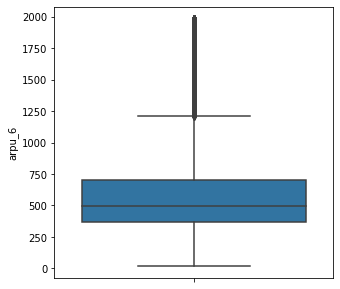

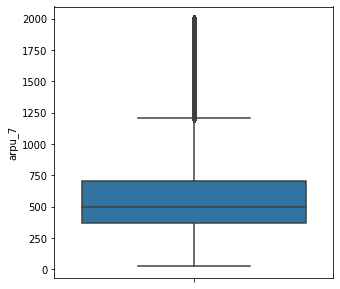

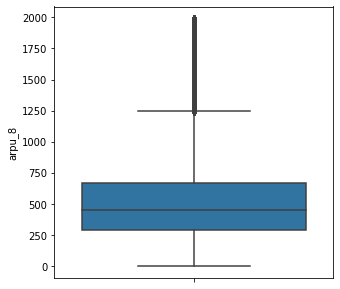

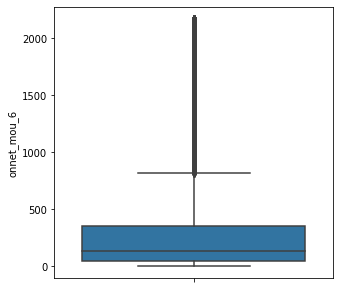

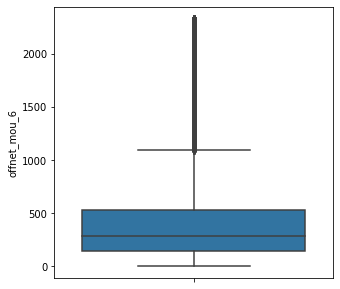

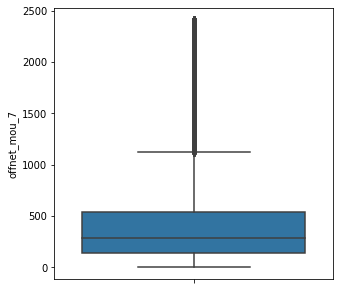

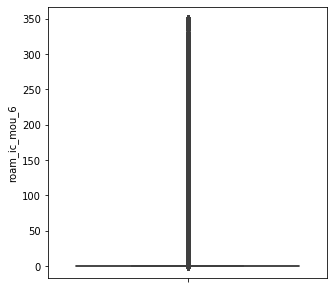

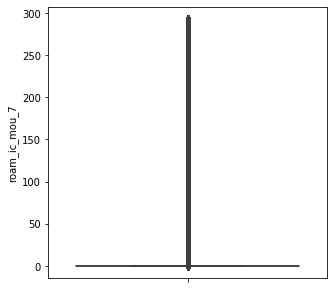

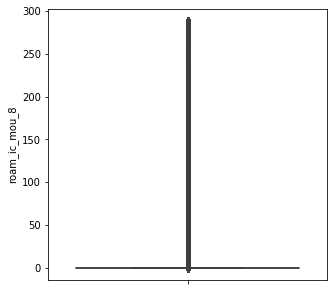

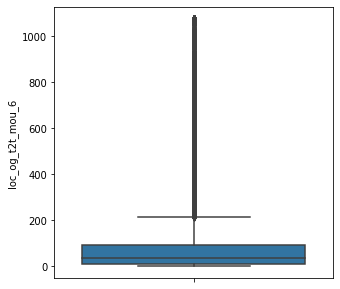

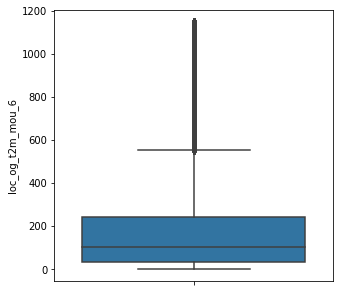

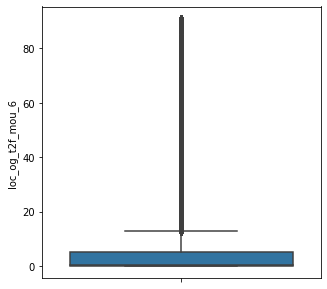

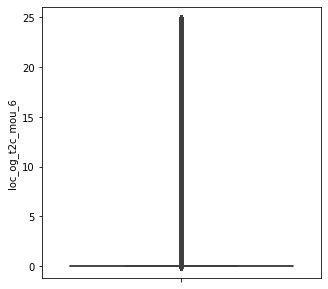

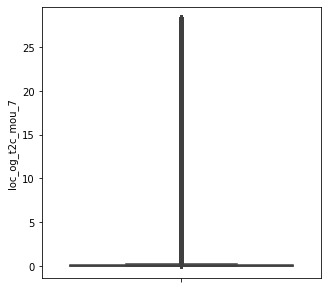

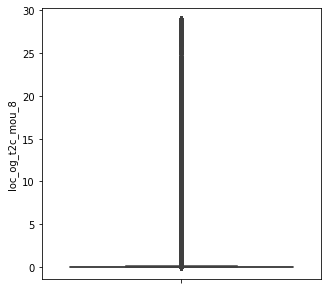

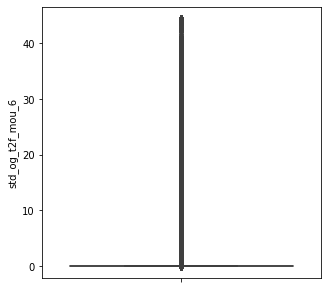

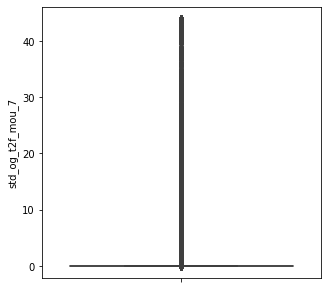

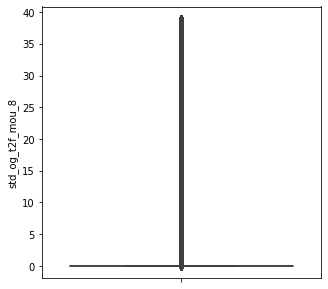

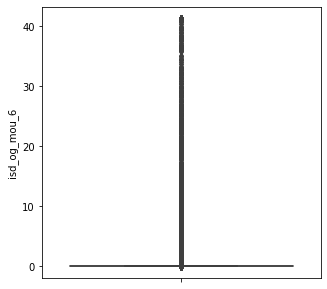

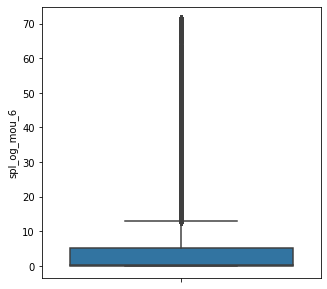

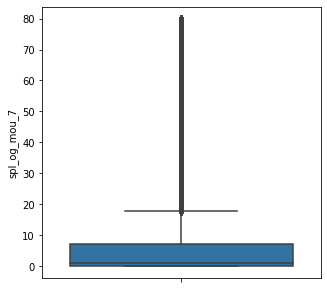

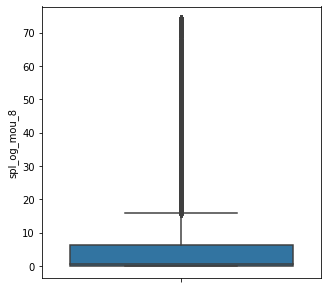

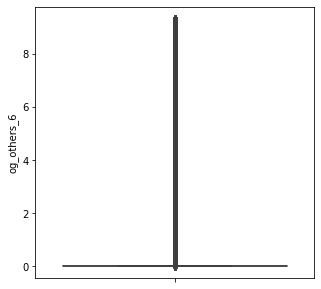

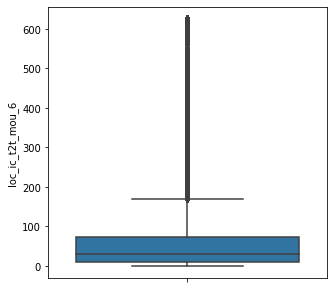

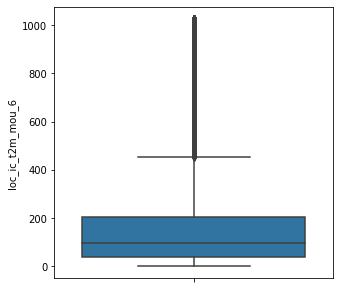

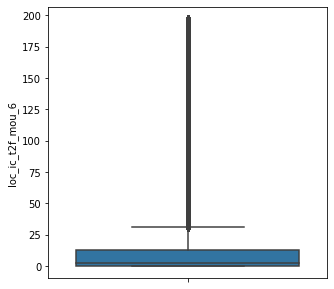

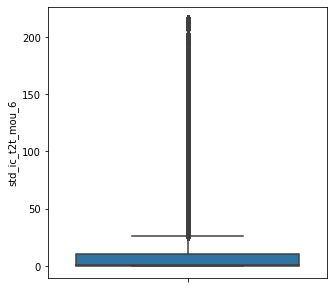

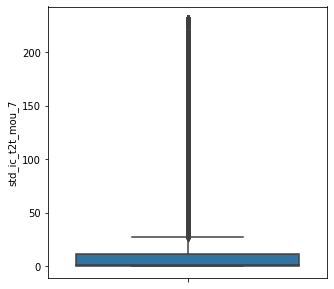

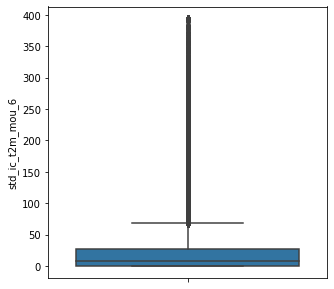

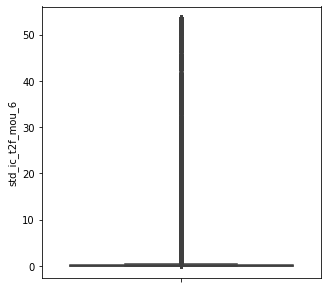

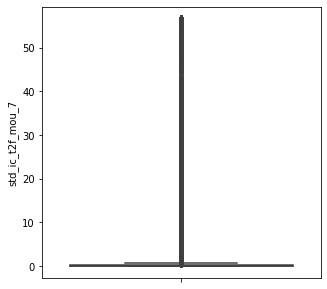

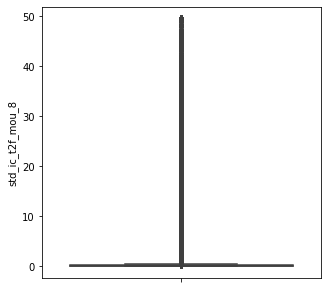

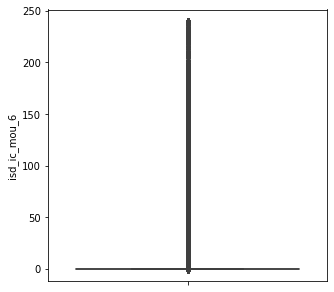

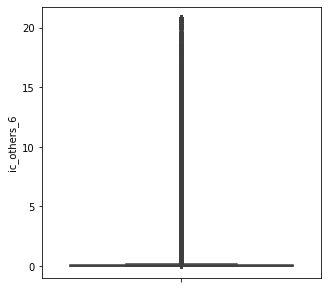

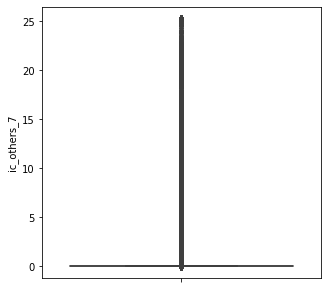

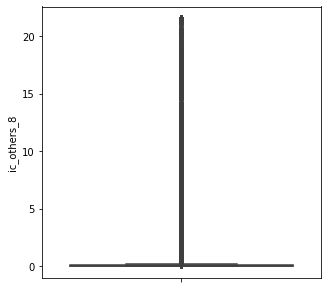

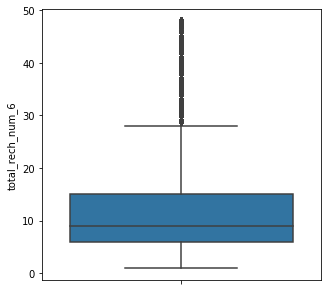

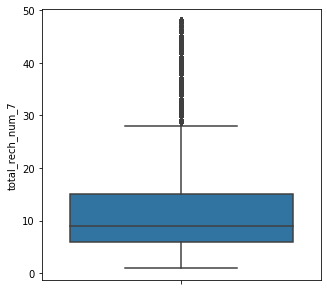

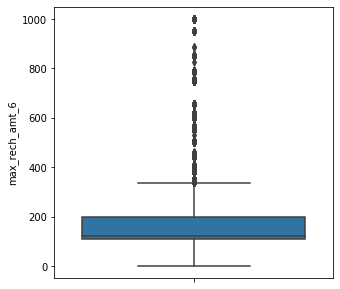

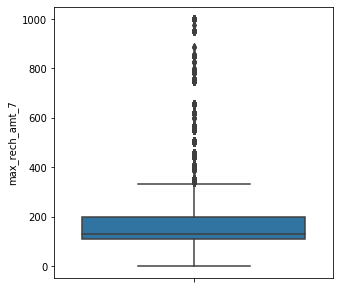

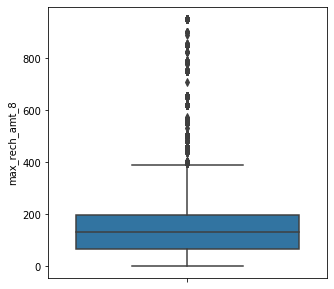

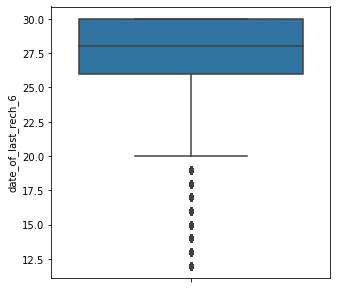

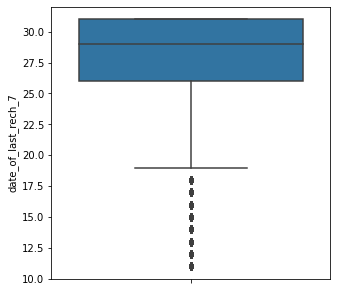

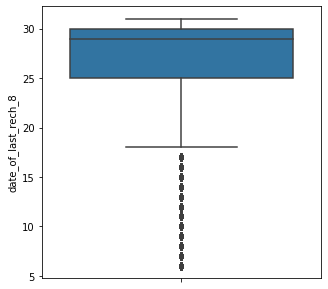

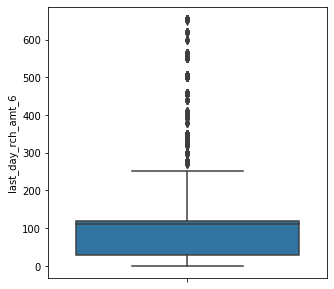

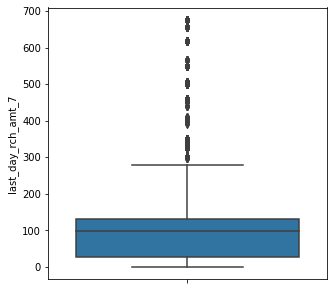

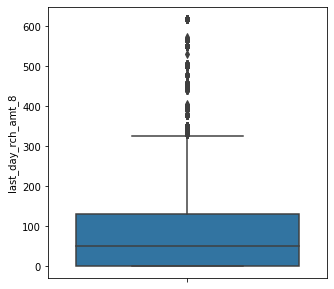

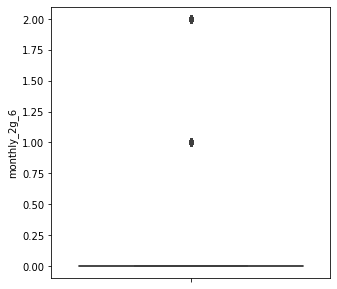

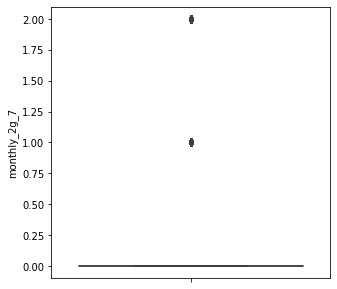

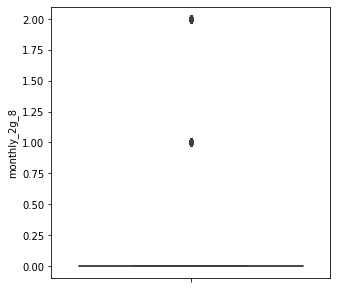

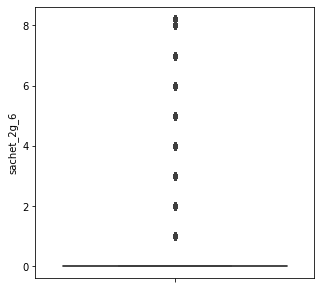

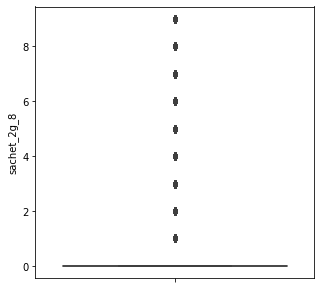

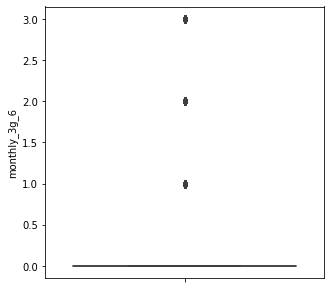

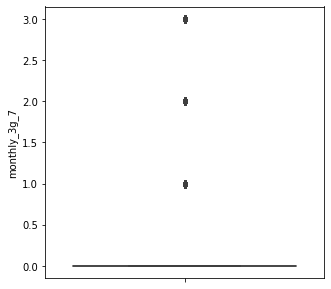

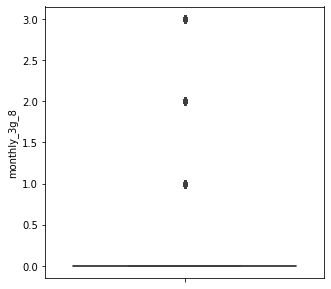

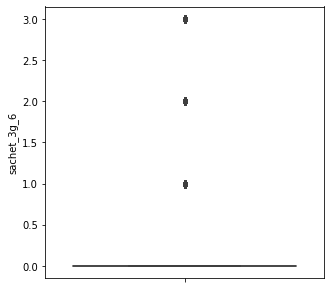

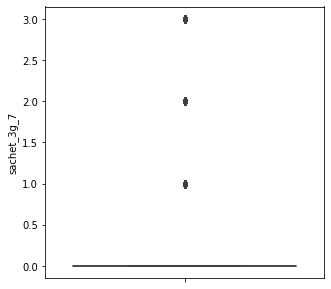

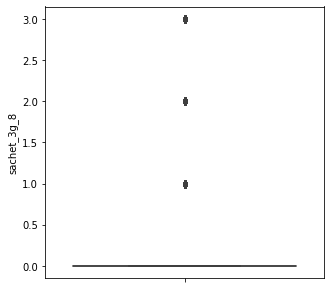

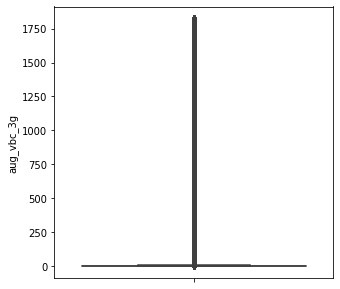

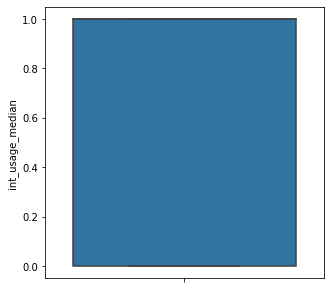

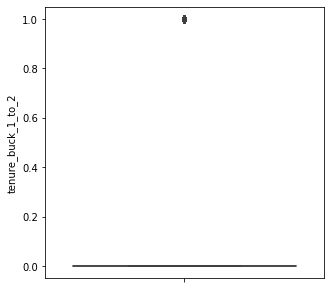

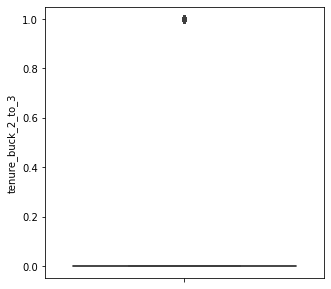

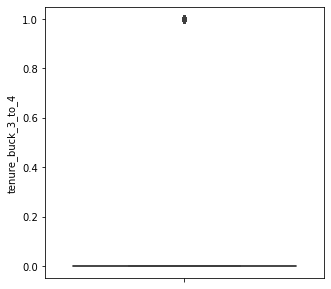

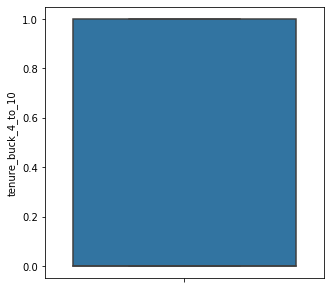

In [30]:
# Checking distribution of data via boxplot
cont_cols = [col for col in telecom_df4.columns if col not in ['churn','mobile_number']]
for col in cont_cols:
    plt.figure(figsize=(5, 5))
    sns.boxplot(y=col, data=telecom_df4)

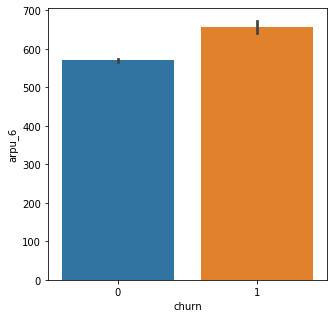

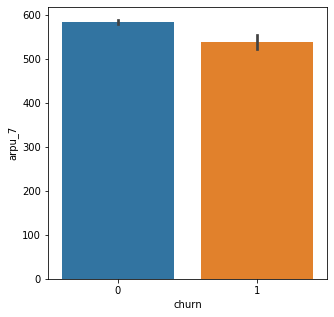

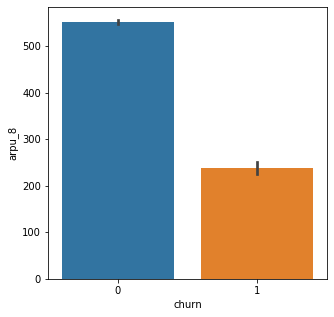

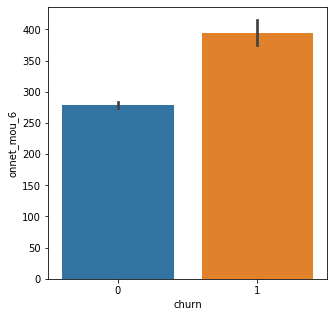

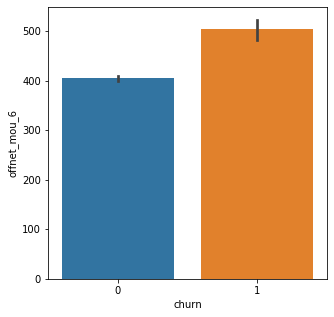

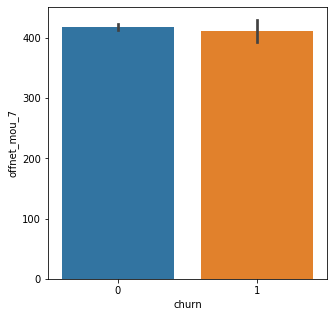

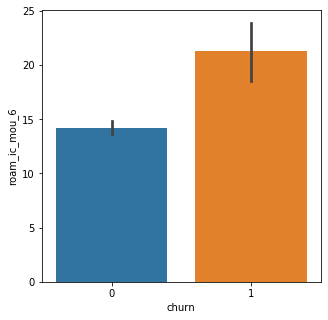

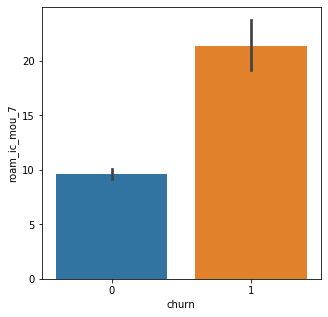

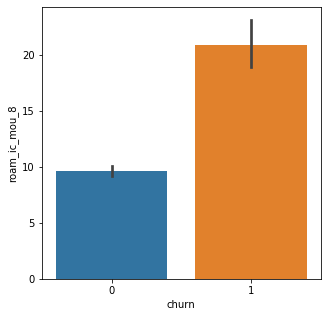

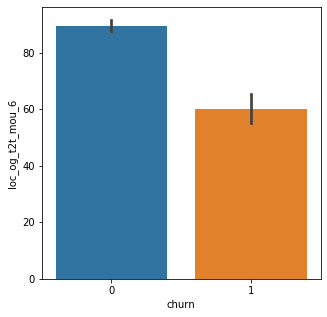

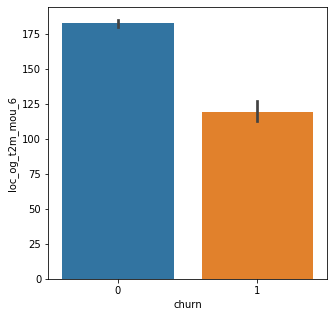

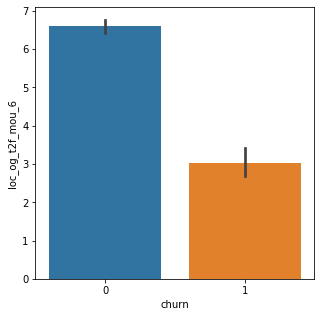

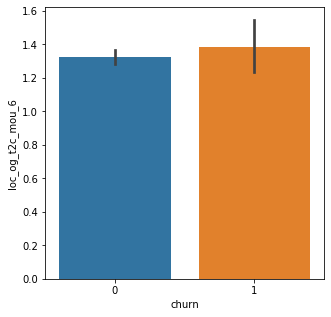

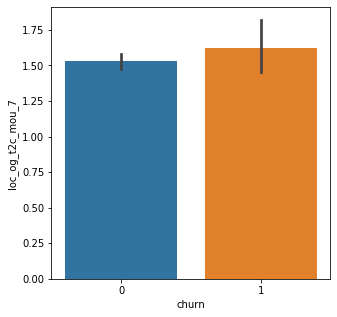

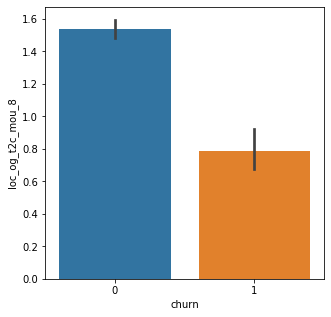

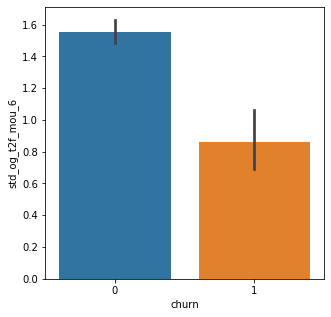

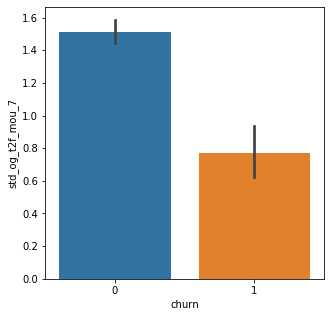

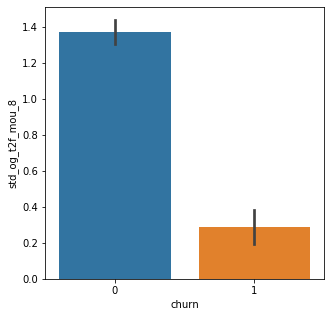

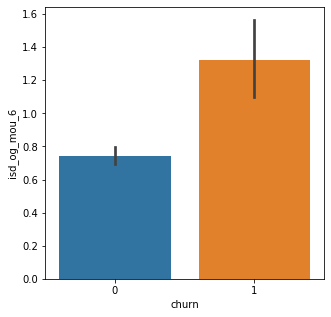

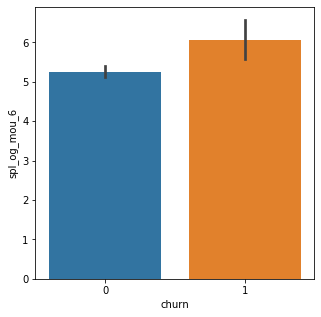

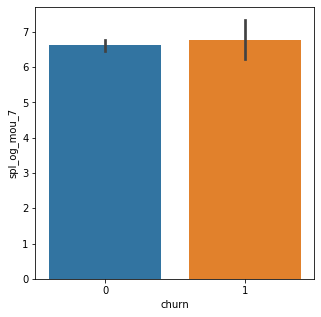

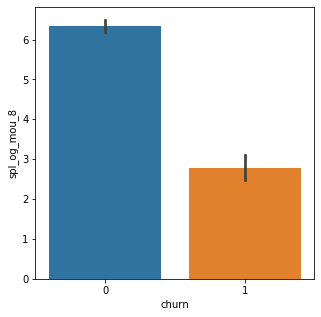

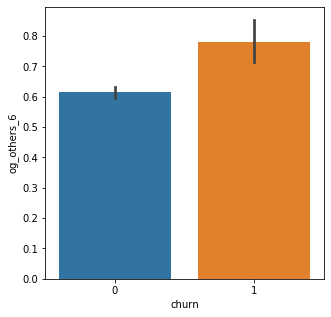

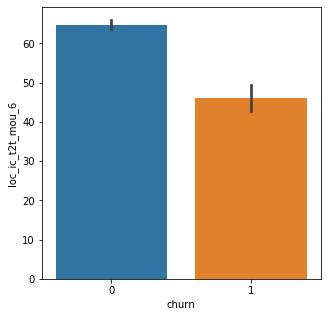

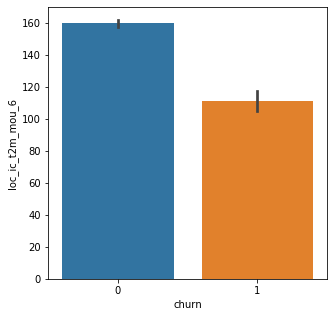

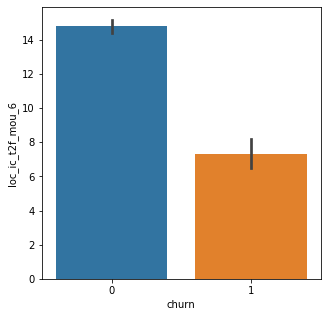

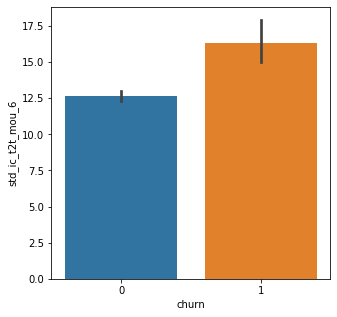

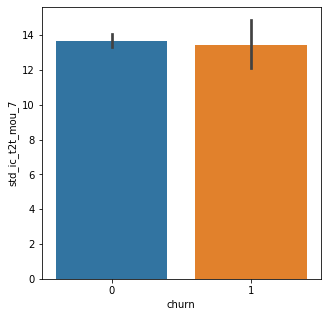

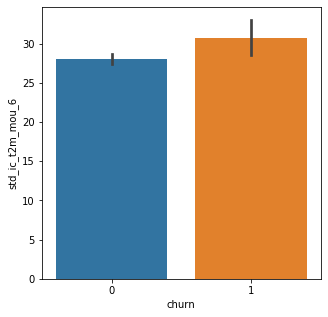

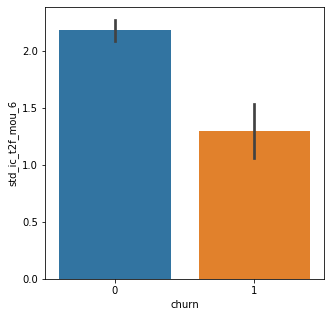

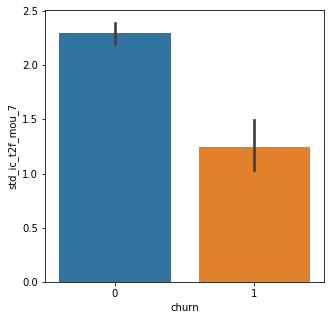

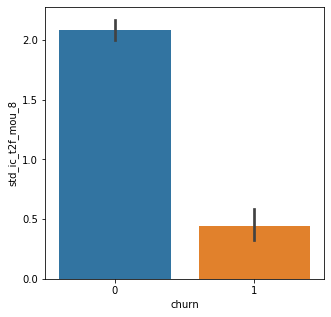

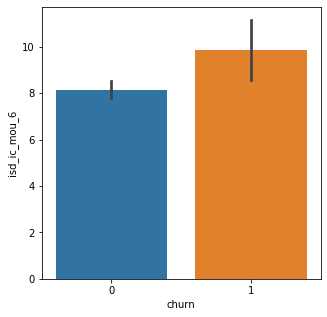

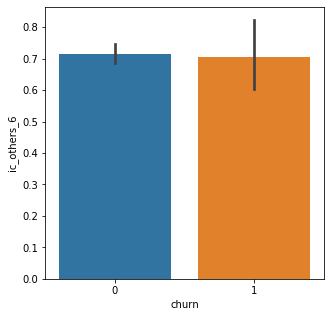

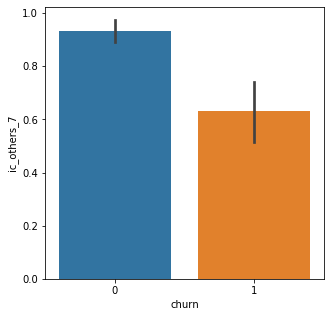

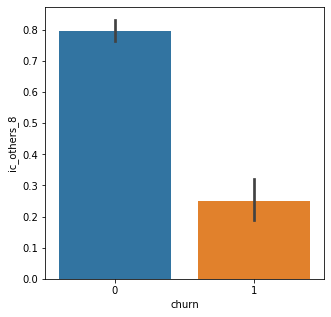

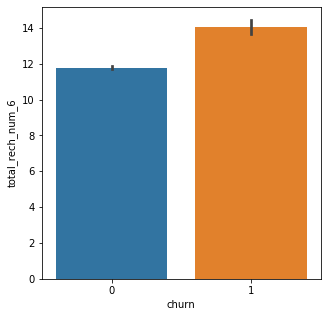

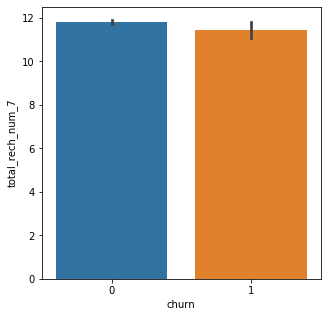

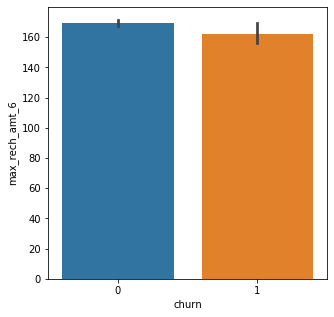

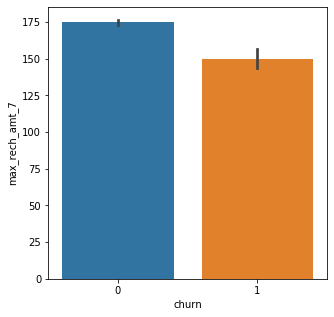

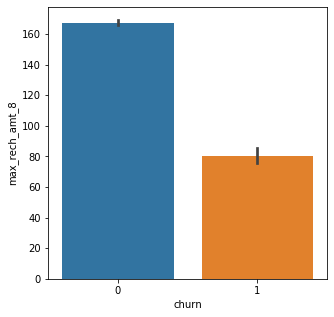

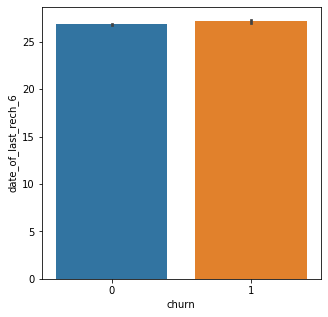

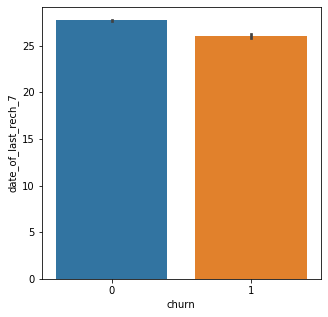

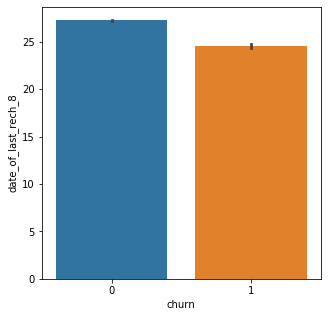

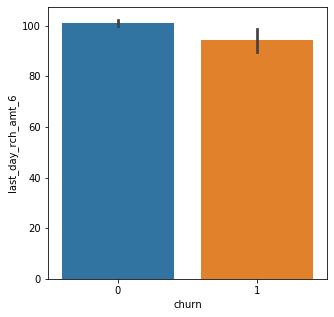

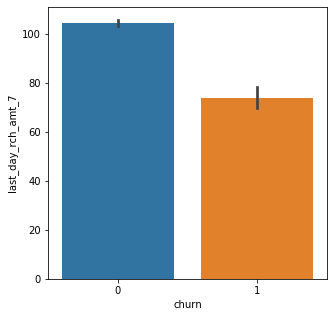

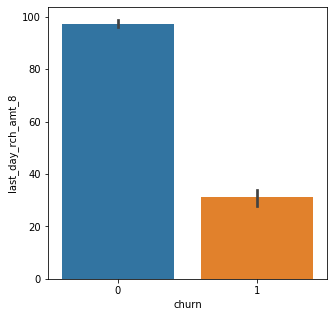

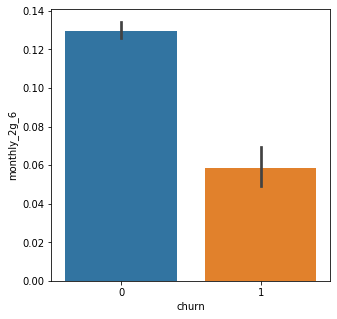

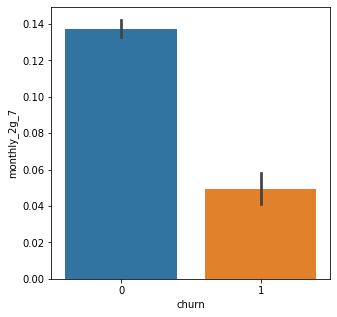

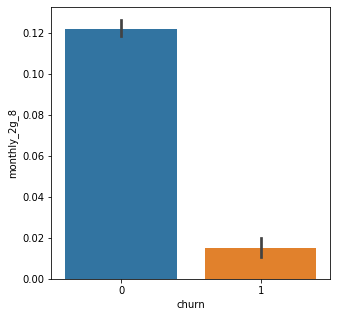

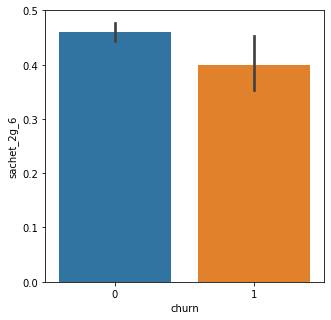

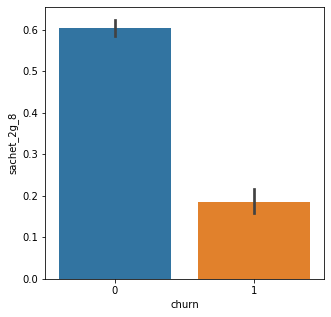

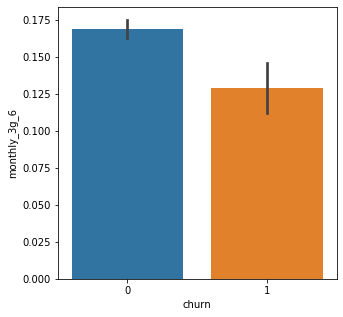

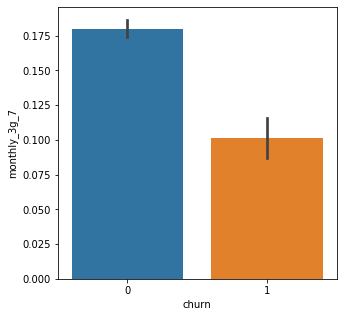

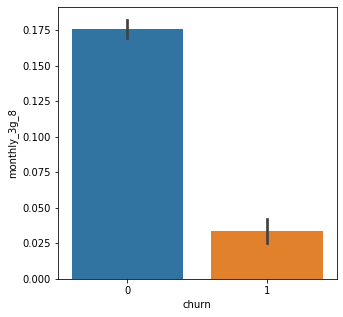

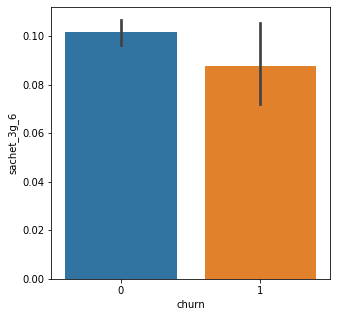

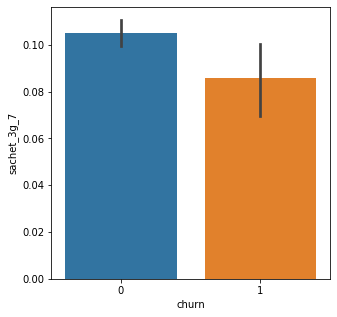

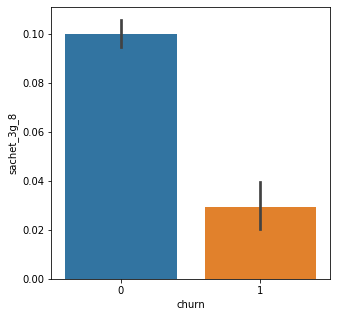

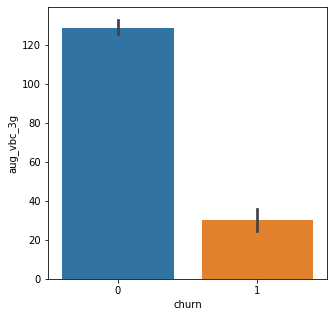

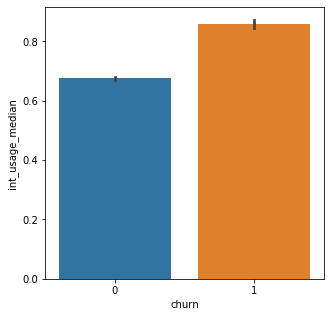

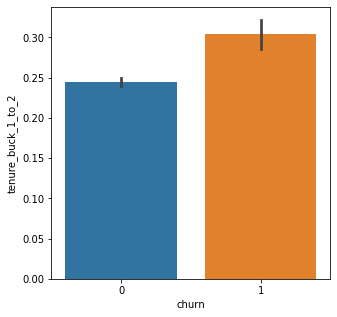

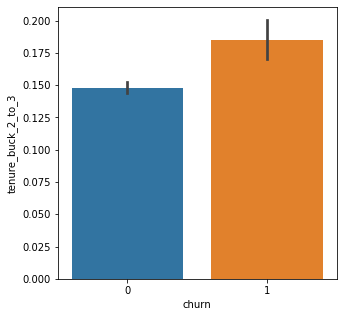

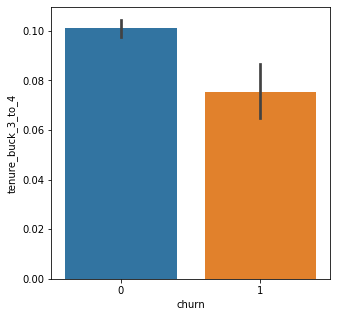

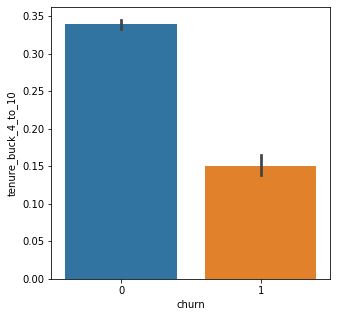

In [31]:
# Bivariate analaysis
cont_cols = [col for col in telecom_df4.columns if col not in ['churn','mobile_number']]
for col in cont_cols:
    plt.figure(figsize=(5, 5))
    sns.barplot(x='churn', y=col, data=telecom_df4)
    plt.show()



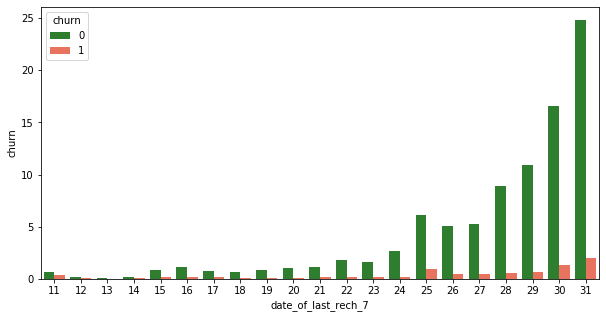

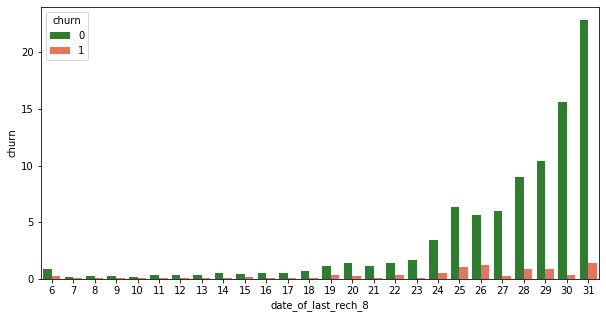

In [32]:
plt.figure(figsize=(10,5))
palette = ["#228B22", "#FF6347"]
sns.barplot(x="date_of_last_rech_7", y="churn", hue="churn", data=telecom_df4, palette=palette, 
            estimator=lambda x: len(x) / len(telecom_df4) * 100)

plt.figure(figsize=(10,5))
palette = ["#228B22", "#FF6347"]
sns.barplot(x="date_of_last_rech_8", y="churn", hue="churn", data=telecom_df4, palette=palette, 
            estimator=lambda x: len(x) / len(telecom_df4) * 100)

In [33]:
# checking shape
telecom_df4.shape

(29979, 66)

In [34]:
#Displaying dataframe
telecom_df5 = telecom_df4
telecom_df5.head()

,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,offnet_mou_6,offnet_mou_7,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,...,sachet_3g_6,sachet_3g_7,sachet_3g_8,aug_vbc_3g,churn,int_usage_median,tenure_buck_1_to_2,tenure_buck_2_to_3,tenure_buck_3_to_4,tenure_buck_4_to_10
7,7000701601,1069.180,1349.8500,1988.08226,57.84,453.43,567.160,16.23,33.49,31.64,...,0,0,0,57.74,1,1,0,1,0,0
8,7001524846,378.721,492.2230,137.36200,413.69,94.66,80.630,0.00,0.00,0.00,...,0,0,0,21.03,0,0,0,0,0,0
13,7002191713,492.846,205.6710,593.26000,501.76,413.31,119.280,23.53,144.24,72.11,...,0,0,0,0.00,0,1,0,0,0,1
16,7000875565,430.975,299.8690,187.89400,50.51,296.29,229.740,0.00,2.83,0.00,...,0,0,0,0.00,0,1,1,0,0,0
17,7000187447,690.008,25.6006,25.49900,1185.91,61.64,1.099,0.00,4.76,4.81,...,0,0,0,0.00,0,1,1,0,0,0


### Model Building
#### Splitting Data into Training and Test Sets

In [35]:
from sklearn.model_selection import train_test_split

# Putting feature variable to X
X = telecom_df5.drop(['churn','mobile_number'],axis=1)

# Putting response variable to y
y = telecom_df5['churn']

# defining a normalisation function 
def normalize (x): 
    return ( (x-np.min(x))/ (max(x) - min(x)))
                                                                                          
# applying normalize ( ) to all columns 
X_norm = X.apply(normalize) 
X_norm.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,offnet_mou_6,offnet_mou_7,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,loc_og_t2t_mou_6,...,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aug_vbc_3g,int_usage_median,tenure_buck_1_to_2,tenure_buck_2_to_3,tenure_buck_3_to_4,tenure_buck_4_to_10
7,0.534739,0.670877,1.000000,0.026693,0.194390,0.234889,0.046432,0.114358,0.109657,0.047732,...,0.0,0.0,0.0,0.0,0.031678,1.0,0.0,1.0,0.0,0.0
8,0.183426,0.236395,0.069093,0.190915,0.040222,0.033002,0.000000,0.000000,0.000000,0.275980,...,0.0,0.0,0.0,0.0,0.011538,0.0,0.0,0.0,0.0,0.0
13,0.241494,0.091225,0.298408,0.231559,0.177150,0.049040,0.067316,0.492536,0.249916,0.046097,...,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,1.0
16,0.210013,0.138947,0.094510,0.023310,0.126865,0.094876,0.000000,0.009664,0.000000,0.039577,...,0.0,0.0,0.0,0.0,0.000000,1.0,1.0,0.0,0.0,0.0
17,0.341812,0.000000,0.012826,0.547290,0.026033,0.000000,0.000000,0.016254,0.016670,0.036215,...,0.0,0.0,0.0,0.0,0.000000,1.0,1.0,0.0,0.0,0.0


In [36]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, train_size=0.7,test_size=0.3,random_state=100)

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (20985, 64)
Number transactions y_train dataset:  (20985,)
Number transactions X_test dataset:  (8994, 64)
Number transactions y_test dataset:  (8994,)


In [37]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

Before OverSampling, counts of label '1': 1774
Before OverSampling, counts of label '0': 19211 



In [38]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_test==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_test==0)))

Before OverSampling, counts of label '1': 815
Before OverSampling, counts of label '0': 8179 



### PCA
- Seems There is a class imbalance in churn event rate
- We can add class_weight = 'balanced'
- Lets do PCA 

In [39]:
#Improting the PCA module
from sklearn.decomposition import PCA
pca = PCA(svd_solver='randomized', random_state=42)

In [40]:
#Doing the PCA on the train data
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
    svd_solver='randomized', tol=0.0, whiten=False)

In [41]:
print(pca.components_)
colnames = list(X_train.columns)
# pcs_df = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'Feature':colnames})
# pcs_df.head(10)
pcs_df = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 
                       'PC3':pca.components_[2],'PC4':pca.components_[3],
                       'PC5':pca.components_[4],'PC6':pca.components_[5],
                       'PC7':pca.components_[6],'PC8':pca.components_[7],
                       'PC9':pca.components_[8],'PC10':pca.components_[9],
                       'Feature':colnames})
pcs_df.head(10)

[[ 2.72571622e-02  3.06854554e-02  5.65711713e-02 ... -1.09443676e-01
  -3.84465767e-02  6.33309364e-01]
 [ 4.18919185e-02  6.04983344e-02  6.45280251e-02 ...  2.57138042e-02
   2.31317494e-02 -4.20050004e-01]
 [ 8.86256922e-03  9.48370467e-03  4.45679598e-03 ...  6.41718066e-01
   1.67836011e-01 -2.97419368e-01]
 ...
 [ 2.69357152e-01  3.88331192e-01 -2.99271458e-01 ... -4.22804574e-03
  -6.00330154e-03 -6.33031438e-03]
 [ 4.63600978e-02  2.09811249e-01 -5.38352863e-02 ...  3.89643721e-03
   9.19224613e-04  1.58662910e-04]
 [-5.87486566e-01  4.24434348e-01  1.24821513e-02 ... -8.03315916e-04
   3.30260691e-03  3.77712162e-03]]


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,Feature
0,0.027257,0.041892,0.008863,-0.025435,0.335408,0.044947,-0.024222,-0.080813,0.004581,-0.160256,arpu_6
1,0.030685,0.060498,0.009484,-0.020675,0.347231,0.045479,0.079954,-0.089717,-0.175575,0.102712,arpu_7
2,0.056571,0.064528,0.004457,-0.009289,0.346802,0.049026,0.088463,-0.094216,-0.195551,0.167722,arpu_8
3,-0.065349,-0.031810,0.015726,-0.059189,0.123000,0.019024,0.060688,-0.006283,-0.035818,-0.103210,onnet_mou_6
4,-0.032633,-0.034933,0.001565,-0.038711,0.307944,0.029847,-0.160777,-0.064776,-0.027720,-0.153454,offnet_mou_6
5,-0.035741,-0.027916,0.000547,-0.035917,0.300139,0.031298,-0.078869,-0.061954,-0.160808,0.032320,offnet_mou_7
6,0.006708,-0.001702,-0.000626,0.033961,0.037511,0.007292,0.059131,-0.039549,-0.085224,0.128832,roam_ic_mou_6
7,0.005179,-0.001149,0.001450,0.037433,0.041556,0.008020,0.037241,-0.038351,-0.057769,0.103260,roam_ic_mou_7
8,0.006896,0.003539,0.001819,0.029578,0.054982,0.005929,0.029720,-0.036005,-0.057183,0.103875,roam_ic_mou_8
9,0.028991,-0.012582,-0.001600,-0.026885,0.097241,0.012368,-0.084338,-0.010365,0.095078,-0.165310,loc_og_t2t_mou_6


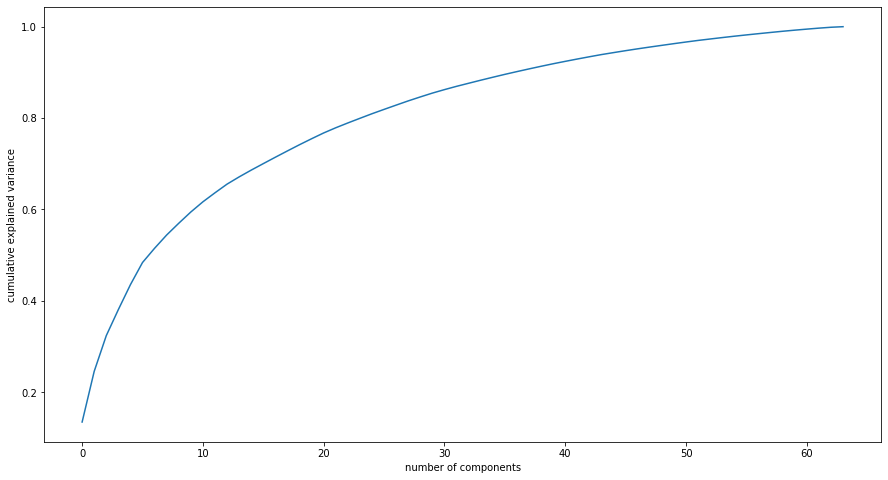

In [42]:
%matplotlib inline
fig = plt.figure(figsize = (15,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

#### As we can see 40 component explain 90% of variance in the data

In [43]:
from sklearn.decomposition import IncrementalPCA
pca_final = IncrementalPCA(n_components=40)

df_train_pca = pca_final.fit_transform(X_train)
df_train_pca.shape

(20985, 40)

### Correlation matrix

In [44]:
#creating correlation matrix for the principal components
corrmat = np.corrcoef(df_train_pca.transpose())


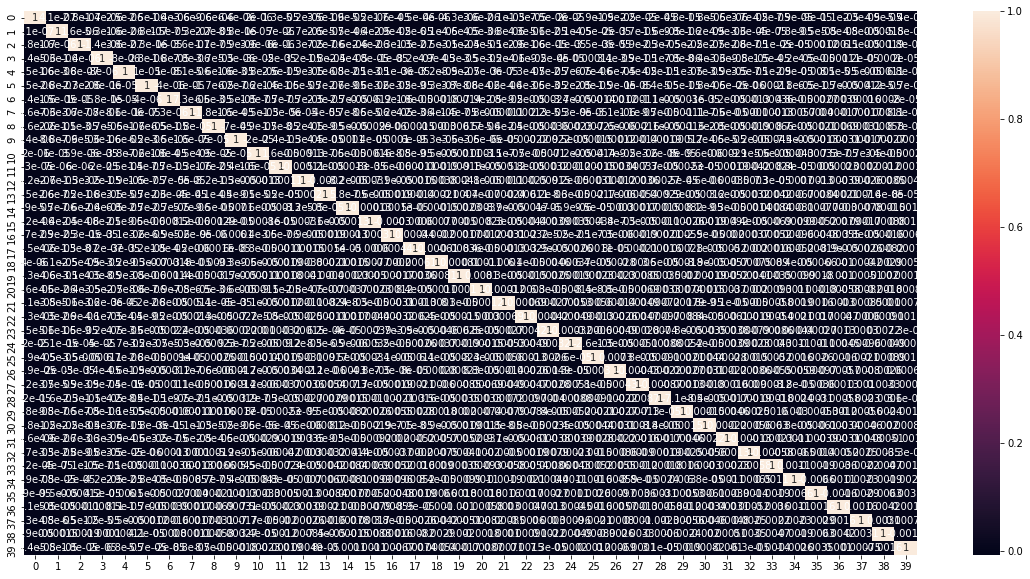

In [45]:
#plotting the correlation matrix
%matplotlib inline
plt.figure(figsize = (20,10))
sns.heatmap(corrmat,annot = True)

In [46]:
# 1s -> 0s in diagonals
corrmat_nodiag = corrmat - np.diagflat(corrmat.diagonal())
print("max corr:",corrmat_nodiag.max(), ", min corr: ", corrmat_nodiag.min(),)
# we see that correlations are indeed very close to 0

max corr: 0.004195136733312188 , min corr:  -0.006584089476803779


In [47]:
#Applying selected components to the test data - 20 components
df_test_pca = pca_final.transform(X_test)
df_test_pca.shape

(8994, 40)

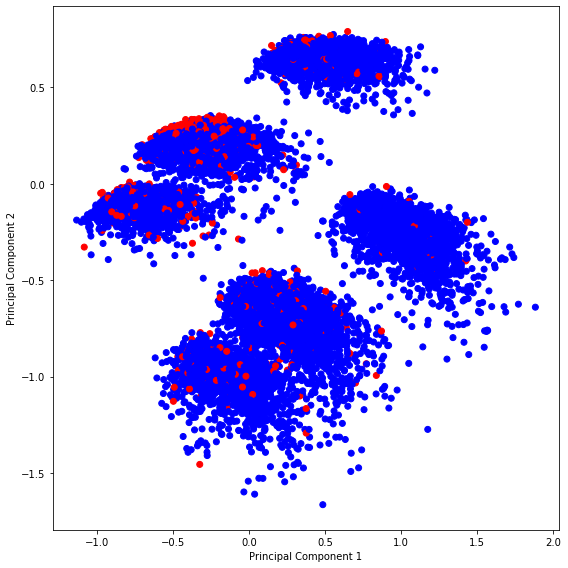

In [48]:
%matplotlib inline
fig = plt.figure(figsize = (8,8))
plt.scatter(df_train_pca[:,0], df_train_pca[:,1], c = y_train.map({0:'blue',1:'red'}))
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.tight_layout()
plt.show()

### LogisticRegression model with PCA
- Now lets do the modeling with selected 40 pca feature 
- We also needs to do the class imbalance with class_width = balanced

In [49]:
#Training the model on the train data
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

learner_pca = LogisticRegression(class_weight='balanced')
model_pca = learner_pca.fit(df_train_pca,y_train)

- Making prediction on the test data

In [50]:

pred_probs_test = model_pca.predict_proba(df_test_pca)[:,1]
"{:2.2}".format(metrics.roc_auc_score(y_test, pred_probs_test))

'0.87'

In [51]:
#Making prediction on the test data
pred_test = model_pca.predict_proba(df_test_pca)
y_pred_default = model_pca.predict(df_test_pca)

In [52]:
# print(classification_report(y_test,y_pred_default))
print(confusion_matrix(y_test,y_pred_default))
print(accuracy_score(y_test,y_pred_default))

[[6641 1538]
 [ 160  655]]
0.8112074716477652


In [53]:
# Converting y_pred to a dataframe which is an array
y_pred_df = pd.DataFrame(pred_test)
# Converting to column dataframe
y_pred_1 = y_pred_df.iloc[:,[1]]

# Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test,y_pred_1],axis=1)

# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 1 : 'churn_prob'})


In [54]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds =roc_curve(y_pred_final.churn,y_pred_final.churn_prob)
roc_auc = auc(fpr, tpr)
print('ROC_AUC score: ',roc_auc)

ROC_AUC score:  0.8675136159714726


### ROC Curve

In [55]:
#ROC Curve
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(6, 6))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return fpr, tpr, thresholds

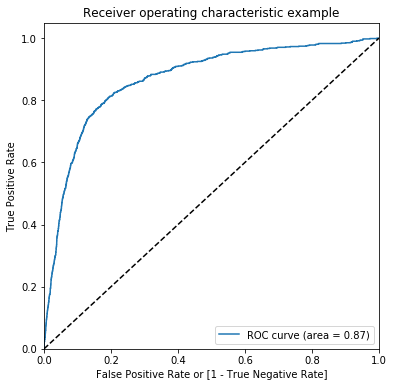

(array([0.        , 0.        , 0.        , ..., 0.99975547, 0.99987774,
        1.        ]),
 array([0.        , 0.00122699, 0.00245399, ..., 1.        , 1.        ,
        1.        ]),
 array([1.99676532e+00, 9.96765322e-01, 9.94136156e-01, ...,
        1.58518125e-04, 6.80538381e-05, 2.72104906e-05]))

In [56]:
draw_roc(y_pred_final.churn, y_pred_final.churn_prob)

In [57]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_pred_final[i]= y_pred_final.churn_prob.map( lambda x: 1 if x > i else 0)
y_pred_final.head()

,churn,churn_prob,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.048375,1,0,0,0,0,0,0,0,0,0
1,0,0.165179,1,1,0,0,0,0,0,0,0,0
2,0,0.158834,1,1,0,0,0,0,0,0,0,0
3,0,0.281039,1,1,1,0,0,0,0,0,0,0
4,0,0.512641,1,1,1,1,1,1,0,0,0,0


- Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.

In [58]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix
num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix( y_pred_final.churn, y_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    sensi = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    speci = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.090616  0.000000  1.000000
0.1   0.1  0.326885  0.262502  0.973006
0.2   0.2  0.503224  0.458858  0.948466
0.3   0.3  0.633422  0.605942  0.909202
0.4   0.4  0.739048  0.727351  0.856442
0.5   0.5  0.811207  0.811957  0.803681
0.6   0.6  0.864020  0.878225  0.721472
0.7   0.7  0.886702  0.914904  0.603681
0.8   0.8  0.904603  0.950972  0.439264
0.9   0.9  0.910496  0.979337  0.219632


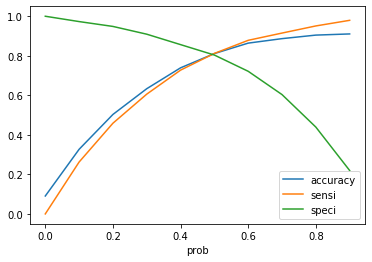

In [59]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])

In [60]:
## Finidng the optimal cutoff
import sys
def Find_Optimal_Cutoff(target, predicted):

    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.loc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold'])

# Find optimal probability threshold
threshold = Find_Optimal_Cutoff(y_pred_final.churn,y_pred_final.churn_prob)
print('Threshold: ',threshold)

Threshold:  [0.4927312227773499]


- Creating new column 'predicted' with 1 if Churn_Prob>0.49 else 0

In [61]:
# Creating new column 'predicted' with 1 if Churn_Prob>0.49 else 0
y_pred_final['pred_churn'] = y_pred_final.churn_prob.map( lambda x: 1 if x > 0.49 else 0)

y_pred_final.churn.value_counts()

0    8179
1     815
Name: churn, dtype: int64

#### Confusion matrix 

In [62]:
# Confusion matrix 
confusion = metrics.confusion_matrix( y_pred_final.churn, y_pred_final.pred_churn )
confusion

array([[6590, 1589],
       [ 155,  660]], dtype=int64)

### Logistic Regression model matrics with PCA

In [63]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

print('Accuracy Score on test data: ', accuracy_score(y_test,y_pred_default))

# Let's see the sensitivity of our logistic regression model
print('Sensitivity: ', TP / float(TP+FN))

# Let us calculate specificity
print('Specificity: ',TN / float(TN+FP))

# Calculate false postive rate - predicting churn when customer does not have churned
print('false postive rate: ',FP/ float(TN+FP))

# positive predictive value 
print('positive predictive value: ', TP / float(TP+FP))

# Negative predictive value
print('Negative predictive value: ',TN / float(TN+ FN))

## Misclassification rate

print('Misclassification Rate: ',(FN+FP)/(TP+TN+FP+FN))

Accuracy Score on test data:  0.8112074716477652
Sensitivity:  0.8098159509202454
Specificity:  0.8057219709010881
false postive rate:  0.19427802909891184
positive predictive value:  0.2934637616718542
Negative predictive value:  0.9770200148257969
Misclassification Rate:  0.1939070491438737


### LogistcRegression model with RFE
- As we have seen with PCA we select 40 component.
- We are selecting 10 feature from RFE

In [64]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(class_weight='balanced')
from sklearn.feature_selection import RFE
rfe = RFE(logreg, 10)             # running RFE with 40 variables as output as PCA gave 40
rfe = rfe.fit(X_norm,y)
print(rfe.support_)           # Printing the boolean results
print(rfe.ranking_)           # Printing the ranking

[ True  True  True False False False False False  True False  True False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False  True False False  True False
 False  True False  True False False  True False False False False False
 False False False False]
[ 1  1  1 26 24 55 20 19  1  7  1  4 35 43 29 32 17  9 25 52 30  6 51 31
 54 13 38 40 39 48 27  2 12 53 47  8 46 45 21  5 50 33 10  1 34 16  1 18
 44  1 28  1 36 23  1 49 15 14  3 37 41 42 22 11]


In [65]:
col = X_train.columns[rfe.support_]
col

Index(['arpu_6', 'arpu_7', 'arpu_8', 'roam_ic_mou_8', 'loc_og_t2m_mou_6',
       'date_of_last_rech_8', 'last_day_rch_amt_8', 'monthly_2g_8',
       'sachet_2g_8', 'monthly_3g_8'],
      dtype='object')

In [66]:
import statsmodels.api as sm
# UDF for calculating vif value
def vif_cal(input_data, dependent_col):
    vif_df = pd.DataFrame( columns = ['Var', 'Vif'])
    x_vars=input_data.drop([dependent_col], axis=1)
    xvar_names=x_vars.columns
    for i in range(0,xvar_names.shape[0]):
        y=x_vars[xvar_names[i]] 
        x=x_vars[xvar_names.drop(xvar_names[i])]
        rsq=sm.OLS(y,x).fit().rsquared  
        vif=round(1/(1-rsq),2)
        vif_df.loc[i] = [xvar_names[i], vif]
    return vif_df.sort_values(by = 'Vif', axis=0, ascending=False, inplace=False)

### Correlation matrix

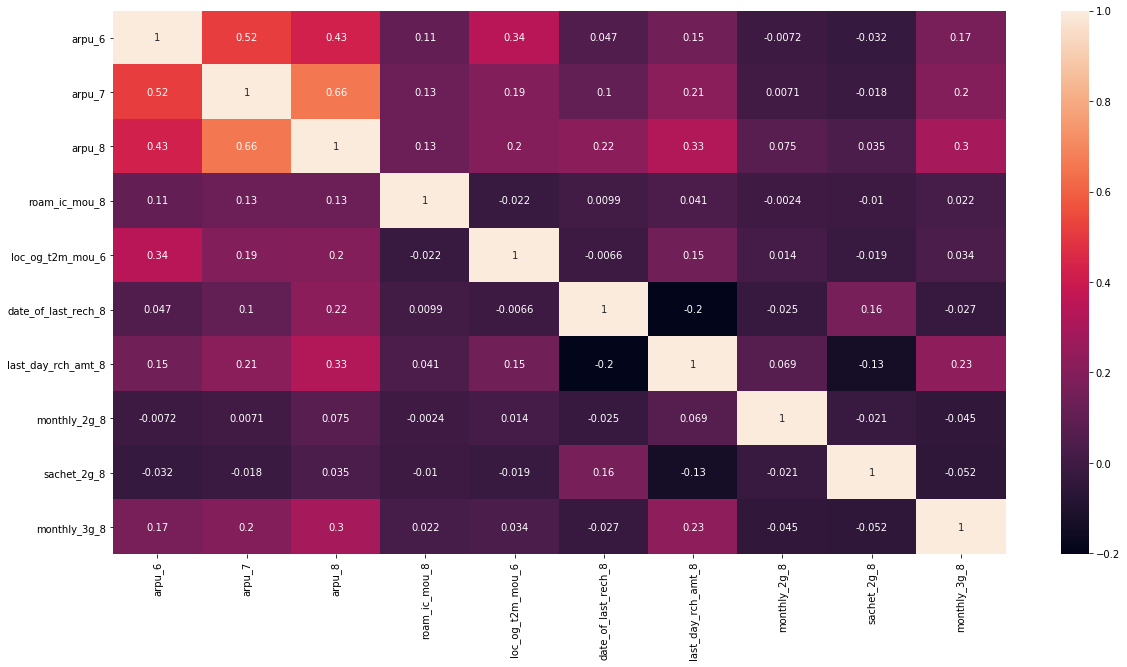

In [67]:
# Let's see the correlation matrix 
plt.figure(figsize = (20,10))        # Size of the figure
sns.heatmap(X_norm[col].corr(),annot = True)

### VIF value

In [68]:
col_for_vif = list(col)
col_for_vif.append('churn')
# telecom_df4.head()
vif_cal(input_data=telecom_df4[col_for_vif], dependent_col='churn')

,Var,Vif
1,arpu_7,7.78
2,arpu_8,6.24
0,arpu_6,5.86
5,date_of_last_rech_8,5.15
4,loc_og_t2m_mou_6,1.95
6,last_day_rch_amt_8,1.94
9,monthly_3g_8,1.26
8,sachet_2g_8,1.19
7,monthly_2g_8,1.12
3,roam_ic_mou_8,1.10


- VIF looks good now will select these coloum for creating LogisticRegression

In [69]:
# Let's run the model using the selected variables
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logsk = LogisticRegression(class_weight='balanced')
logsk.fit(X_train[col], y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

#### ROC_AUC score

In [70]:
#Making prediction on the test data
pred_probs_test = logsk.predict_proba(X_test[col])[:,1]
"{:2.2}".format(metrics.roc_auc_score(y_test, pred_probs_test))

'0.86'

In [71]:

#Making prediction on the test data
pred_test = logsk.predict_proba(X_test[col])
y_pred_default = logsk.predict(X_test[col])

In [72]:
print(classification_report(y_test,y_pred_default))
print(confusion_matrix(y_test,y_pred_default))
print('accuracy_score : ',accuracy_score(y_test,y_pred_default))

              precision    recall  f1-score   support

           0       0.98      0.81      0.89      8179
           1       0.30      0.81      0.44       815

    accuracy                           0.81      8994
   macro avg       0.64      0.81      0.66      8994
weighted avg       0.92      0.81      0.85      8994

[[6644 1535]
 [ 158  657]]
accuracy_score :  0.8117633978207695


In [73]:

# Converting y_pred to a dataframe which is an array
y_pred_df = pd.DataFrame(pred_test)
# Converting to column dataframe
y_pred_1 = y_pred_df.iloc[:,[1]]

# Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test,y_pred_1],axis=1)

# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 1 : 'churn_prob'})


In [74]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds =roc_curve(y_pred_final.churn,y_pred_final.churn_prob)
roc_auc = auc(fpr, tpr)
print('ROC_AUC Score: ',roc_auc)

ROC_AUC Score:  0.8641736243574558


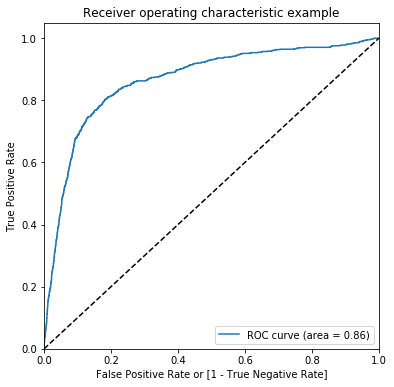

(array([0.00000000e+00, 1.22264335e-04, 1.22264335e-04, ...,
        9.99755471e-01, 9.99877736e-01, 1.00000000e+00]),
 array([0.        , 0.        , 0.00122699, ..., 1.        , 1.        ,
        1.        ]),
 array([1.99837954e+00, 9.98379540e-01, 9.96324019e-01, ...,
        3.47740996e-05, 3.20145109e-05, 9.67337200e-06]))

In [75]:
draw_roc(y_pred_final.churn, y_pred_final.churn_prob)

In [76]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_pred_final[i]= y_pred_final.churn_prob.map( lambda x: 1 if x > i else 0)
y_pred_final.head()


,churn,churn_prob,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.041235,1,0,0,0,0,0,0,0,0,0
1,0,0.152074,1,1,0,0,0,0,0,0,0,0
2,0,0.336435,1,1,1,1,0,0,0,0,0,0
3,0,0.146296,1,1,0,0,0,0,0,0,0,0
4,0,0.505226,1,1,1,1,1,1,0,0,0,0


In [77]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix
num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix( y_pred_final.churn, y_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    sensi = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    speci = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.090616  0.000000  1.000000
0.1   0.1  0.294196  0.226923  0.969325
0.2   0.2  0.455192  0.405795  0.950920
0.3   0.3  0.600067  0.569263  0.909202
0.4   0.4  0.725150  0.711456  0.862577
0.5   0.5  0.811763  0.812324  0.806135
0.6   0.6  0.862909  0.876024  0.731288
0.7   0.7  0.890371  0.917838  0.614724
0.8   0.8  0.905715  0.955496  0.406135
0.9   0.9  0.911274  0.984595  0.175460


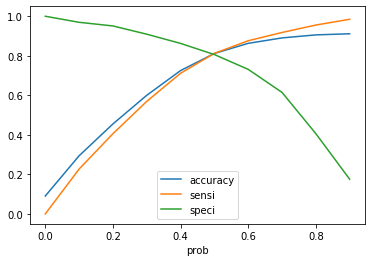

In [78]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])

In [79]:
## Finidng the optimal cutoff
def Find_Optimal_Cutoff(target, predicted):

    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.loc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold'])

# Find optimal probability threshold
threshold = Find_Optimal_Cutoff(y_pred_final.churn,y_pred_final.churn_prob)
print('CutOff threshold: ', threshold)

CutOff threshold:  [0.49455810138630424]


In [80]:
# Creating new column 'predicted' with 1 if Churn_Prob>0.49 else 0
y_pred_final['pred_churn'] = y_pred_final.churn_prob.map( lambda x: 1 if x > 0.49 else 0)

y_pred_final.churn.value_counts()


0    8179
1     815
Name: churn, dtype: int64

In [81]:
# Confusion matrix 
confusion = metrics.confusion_matrix( y_pred_final.churn, y_pred_final.pred_churn )
confusion

array([[6583, 1596],
       [ 154,  661]], dtype=int64)

In [82]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

print('Accuracy Score : ',accuracy_score(y_test,y_pred_default))

# Let's see the sensitivity of our logistic regression model
print('Sensitivity: ', TP / float(TP+FN))

# Let us calculate specificity
print('Specificity: ',TN / float(TN+FP))

# Calculate false postive rate - predicting churn when customer does not have churned
print('false postive rate: ',FP/ float(TN+FP))

# positive predictive value 
print('positive predictive value: ', TP / float(TP+FP))

# Negative predictive value
print('Negative predictive value: ',TN / float(TN+ FN))

Accuracy Score :  0.8117633978207695
Sensitivity:  0.811042944785276
Specificity:  0.8048661205526348
false postive rate:  0.1951338794473652
positive predictive value:  0.2928666371289322
Negative predictive value:  0.9771411607540448


#### From above we can see LogisticRegression giving good Accuracy with PCA and with RFE

#### With PCA
- Accuracy Score on test data:  0.8112074716477652
- Sensitivity:  0.8098159509202454
- Specificity:  0.8057219709010881
- false postive rate:  0.19427802909891184
- positive predictive value:  0.2934637616718542
- Negative predictive value:  0.9770200148257969
- Misclassification Rate:  0.1939070491438737


#### With RFE
- Accuracy Score :  0.8117633978207695
- Sensitivity:  0.811042944785276
- Specificity:  0.8048661205526348
- false postive rate:  0.1951338794473652
- positive predictive value:  0.2928666371289322
- Negative predictive value:  0.9771411607540448


### DecisionTreeClassifier With PCA

In [83]:
# Importing decision tree classifier from sklearn library
from sklearn.tree import DecisionTreeClassifier

# Fitting the decision tree with default hyperparameters, apart from
# max_depth which is 5 so that we can plot and read the tree.
dt_default = DecisionTreeClassifier(max_depth=5, class_weight='balanced')
dt_default.fit(df_train_pca,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [84]:
# Let's check the evaluation metrics of our default model

# Importing classification report and confusion matrix from sklearn metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Making predictions
y_pred_default = dt_default.predict(df_test_pca)

# # Printing classification report
# print(classification_report(y_test, y_pred_default))

# from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
print(classification_report(y_test,y_pred_default))
print(confusion_matrix(y_test,y_pred_default))
print('Acuracy Score', accuracy_score(y_test,y_pred_default))

              precision    recall  f1-score   support

           0       0.96      0.81      0.87      8179
           1       0.24      0.62      0.35       815

    accuracy                           0.79      8994
   macro avg       0.60      0.71      0.61      8994
weighted avg       0.89      0.79      0.83      8994

[[6586 1593]
 [ 308  507]]
Acuracy Score 0.7886368690237936


In [85]:
confusion_tree = confusion_matrix(y_test,y_pred_default)
TP = confusion_tree[1,1] # true positive 
TN = confusion_tree[0,0] # true negatives
FP = confusion_tree[0,1] # false positives
FN = confusion_tree[1,0] # false negatives

print('Acuracy Score', accuracy_score(y_test,y_pred_default))

# Let's see the sensitivity of our logistic regression model
print('Sensitivity: ', TP / float(TP+FN))

# Let us calculate specificity
print('Specificity: ',TN / float(TN+FP))

# Calculate false postive rate - predicting churn when customer does not have churned
print('false postive rate: ',FP/ float(TN+FP))

# positive predictive value 
print('positive predictive value: ', TP / float(TP+FP))

# Negative predictive value
print('Negative predictive value: ',TN / float(TN+ FN))

## Misclassification rate

print('Misclassification Rate: ',(FN+FP)/(TP+TN+FP+FN))

Acuracy Score 0.7886368690237936
Sensitivity:  0.6220858895705521
Specificity:  0.8052329135591149
false postive rate:  0.1947670864408852
positive predictive value:  0.24142857142857144
Negative predictive value:  0.955323469683783
Misclassification Rate:  0.21136313097620635


- As we can see above Sensitivity of model is not great let's tune the Hyperparameter

### Hyperparameter tuning

In [86]:
########## lets tune hyper parameterss
# GridSearchCV to find optimal max_depth
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(1, 40)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini", class_weight='balanced', random_state = 100)

# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                   scoring="accuracy")
tree.fit(df_train_pca,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=100,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'m

In [87]:
y_train.shape

(20985,)

In [88]:
# scores of GridSearch CV
scores = tree.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.102438,0.010962,0.001037,0.000076,1,{'max_depth': 1},0.627591,0.553014,0.487253,0.506552,0.542292,0.543340,0.048357,39
1,0.179572,0.012052,0.001010,0.000023,2,{'max_depth': 2},0.804861,0.741959,0.752680,0.751966,0.770312,0.764355,0.022215,32
2,0.246128,0.014746,0.001385,0.000501,3,{'max_depth': 3},0.750774,0.684060,0.652371,0.595425,0.700024,0.676531,0.051541,38
3,0.312064,0.019660,0.000995,0.000036,4,{'max_depth': 4},0.704313,0.774124,0.753395,0.733143,0.749345,0.742864,0.023284,34
4,0.368431,0.009338,0.001002,0.000039,5,{'max_depth': 5},0.754110,0.770550,0.745294,0.704074,0.713843,0.737574,0.024923,35


In [89]:
## Lets tune min sample leaf
# parameters to build the model on
parameters = {'min_samples_leaf': range(5, 200, 20)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini",class_weight='balanced',random_state = 100)

# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds,
                    return_train_score=True,
                   scoring="accuracy")
tree.fit(df_train_pca,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=100,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'m

In [90]:
# scores of GridSearch CV
scores = tree.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.752947,0.087836,0.001127,0.000249,5,{'min_samples_leaf': 5},0.839886,0.838694,0.844651,0.843698,...,0.842316,0.002523,1,0.935073,0.935430,0.941685,0.941268,0.936145,0.937920,0.002927
1,0.646432,0.037678,0.001411,0.000485,25,{'min_samples_leaf': 25},0.770550,0.786514,0.753634,0.771503,...,0.770693,0.010415,2,0.833572,0.834108,0.811472,0.822314,0.813736,0.823040,0.009532
2,0.585154,0.030954,0.001621,0.000458,45,{'min_samples_leaf': 45},0.747439,0.750536,0.714558,0.742912,...,0.738813,0.012783,4,0.791339,0.786991,0.770670,0.785919,0.777341,0.782452,0.007437
3,0.567170,0.042554,0.001210,0.000485,65,{'min_samples_leaf': 65},0.730045,0.739338,0.724565,0.730760,...,0.736669,0.011958,5,0.763879,0.773707,0.764892,0.771563,0.784489,0.771706,0.007418
4,0.520745,0.025625,0.001545,0.000521,85,{'min_samples_leaf': 85},0.743626,0.720991,0.740052,0.738146,...,0.739957,0.011540,3,0.772993,0.753097,0.776030,0.771265,0.776328,0.769943,0.008633


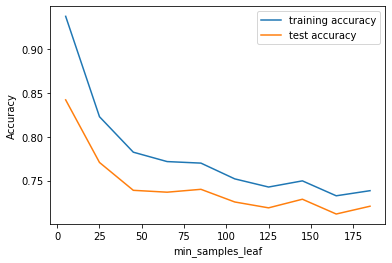

In [91]:
# plotting accuracies with min_samples_leaf
plt.figure()
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

#seems 5 to 150

In [92]:
## Tuning min sample split
# parameters to build the model on
parameters = {'min_samples_split': range(5, 200, 20)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini",class_weight='balanced', random_state = 100)

# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds,
                    return_train_score=True,
                   scoring="accuracy")
tree.fit(df_train_pca,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=100,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'m

In [93]:
# scores of GridSearch CV
scores = tree.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.874469,0.171610,0.001190,0.000400,5,{'min_samples_split': 5},0.877770,0.875864,0.879676,0.881582,...,0.878914,0.001944,1,0.995175,0.994103,0.995413,0.992673,0.993746,0.994222,0.000997
1,0.780085,0.022368,0.001204,0.000396,25,{'min_samples_split': 25},0.831308,0.833214,0.828925,0.834167,...,0.831403,0.002053,2,0.936145,0.933584,0.925542,0.926793,0.922862,0.928985,0.005031
2,0.735633,0.039049,0.001187,0.000408,45,{'min_samples_split': 45},0.807958,0.798427,0.789850,0.799142,...,0.797713,0.006162,3,0.892483,0.883905,0.875030,0.878485,0.867644,0.879509,0.008361
3,0.746212,0.048027,0.001628,0.000517,65,{'min_samples_split': 65},0.783178,0.780319,0.766738,0.776269,...,0.776412,0.005575,4,0.854837,0.851025,0.843400,0.847391,0.837443,0.846819,0.006031
4,0.709738,0.017558,0.001593,0.000375,85,{'min_samples_split': 85},0.770789,0.762449,0.758399,0.761258,...,0.762545,0.004340,5,0.829283,0.824756,0.826721,0.822373,0.817846,0.824196,0.003904


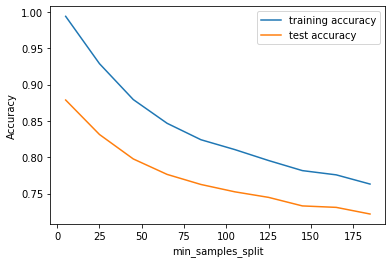

In [94]:
# plotting accuracies with min_samples_split
plt.figure()
plt.plot(scores["param_min_samples_split"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_split"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [95]:
# Create the parameter grid 
param_grid = {
    'max_depth': range(5, 15, 5),
    'min_samples_leaf': range(5, 200, 20),
    'min_samples_split': range(5, 200, 20),
    'criterion': ["entropy", "gini"]
}

n_folds = 5

# Instantiate the grid search model
dtree = DecisionTreeClassifier(class_weight='balanced')
grid_search = GridSearchCV(estimator = dtree, param_grid = param_grid, refit='recall_score',
                          cv = n_folds, verbose = 1, n_jobs = -1)

# Fit the grid search to the data
grid_search.fit(df_train_pca,y_train)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   41.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  6.5min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'cr

In [96]:
# cv results
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.855826,0.187217,0.003945,0.000563,entropy,5,5,5,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.749345,0.712175,0.730284,0.703598,0.768168,0.732714,0.023703,159
1,1.844204,0.207404,0.003958,0.000806,entropy,5,5,25,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.749345,0.712175,0.730284,0.703598,0.768168,0.732714,0.023703,159
2,1.663321,0.038072,0.002983,0.000154,entropy,5,5,45,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.749345,0.712175,0.730284,0.703598,0.768168,0.732714,0.023703,159
3,1.605409,0.044312,0.002993,0.000001,entropy,5,5,65,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.749345,0.711699,0.726710,0.703598,0.768168,0.731904,0.023899,165
4,1.609562,0.052783,0.003129,0.000274,entropy,5,5,85,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.749345,0.712175,0.726710,0.703598,0.768168,0.731999,0.023819,164


In [97]:
# printing the optimal accuracy score and hyperparameters
print("best accuracy", grid_search.best_score_)
print(grid_search.best_estimator_)

best accuracy 0.790421729807005
DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


In [98]:
# model with optimal hyperparameters
clf_gini = DecisionTreeClassifier(criterion = "gini",class_weight='balanced',
                                  random_state = 100,
                                  max_depth=10, 
                                  min_samples_leaf=5,
                                  min_samples_split=5)
clf_gini.fit(df_train_pca,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=100, splitter='best')

In [99]:
y_pred_default = clf_gini.predict(df_test_pca)
confusion_tree_hyper=confusion_matrix(y_test,y_pred_default)
confusion_tree_hyper

array([[6541, 1638],
       [ 307,  508]], dtype=int64)

In [100]:
TP = confusion_tree_hyper[1,1] # true positive 
TN = confusion_tree_hyper[0,0] # true negatives
FP = confusion_tree_hyper[0,1] # false positives
FN = confusion_tree_hyper[1,0] # false negatives

# Let's see the sensitivity of our logistic regression model
print('Sensitivity: ', TP / float(TP+FN))

# Let us calculate specificity
print('Specificity: ',TN / float(TN+FP))

# Calculate false postive rate - predicting churn when customer does not have churned
print('false postive rate: ',FP/ float(TN+FP))

# positive predictive value 
print('positive predictive value: ', TP / float(TP+FP))

# Negative predictive value
print('Negative predictive value: ',TN / float(TN+ FN))

## Misclassification rate

print('Misclassification Rate: ',(FN+FP)/(TP+TN+FP+FN))

Sensitivity:  0.6233128834355828
Specificity:  0.7997310184619146
false postive rate:  0.20026898153808534
positive predictive value:  0.23671947809878843
Negative predictive value:  0.9551693925233645
Misclassification Rate:  0.21625528129864355


### RandomForestClassifier with PCA

In [101]:
# Random forest

# Importing random forest classifier from sklearn library
from sklearn.ensemble import RandomForestClassifier

# Running the random forest with default parameters.
rfc = RandomForestClassifier(class_weight='balanced')

# fit
rfc.fit(df_train_pca,y_train)

# Making predictions
y_pred_default = rfc.predict(df_test_pca)

In [102]:
confusion_rf=confusion_matrix(y_test,y_pred_default)
confusion_rf

array([[8147,   32],
       [ 754,   61]], dtype=int64)

In [103]:
TN = confusion_rf[0,0] # true positive 
TP = confusion_rf[1,1] # true negatives
FP = confusion_rf[0,1] # false positives
FN = confusion_rf[1,0] # false negatives

# Let's see the sensitivity of our logistic regression model
print('Sensitivity: ', TP / float(TP+FN))

# Let us calculate specificity
print('Specificity: ',TN / float(TN+FP))

# Calculate false postive rate - predicting churn when customer does not have churned
print('false postive rate: ',FP/ float(TN+FP))

# positive predictive value 
print('positive predictive value: ', TP / float(TP+FP))

# Negative predictive value
print('Negative predictive value: ',TN / float(TN+ FN))

## Misclassification rate

print('Misclassification Rate: ',(FN+FP)/(TP+TN+FP+FN))

Sensitivity:  0.07484662576687116
Specificity:  0.9960875412642133
false postive rate:  0.003912458735786771
positive predictive value:  0.6559139784946236
Negative predictive value:  0.9152904168071003
Misclassification Rate:  0.08739159439626418


### Hyperparameter tuning for RandomForest

In [104]:
#Lets do some hyper parameter tuning 
# GridSearchCV to find optimal n_estimators
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# specify number of folds for k-fold CV
n_folds = 5
# parameters to build the model on
parameters = {'max_depth': range(2, 20, 5)}

# instantiate the model
rf_with_pca = RandomForestClassifier(class_weight='balanced')


# fit tree on training data
rf_with_pca = GridSearchCV(rf_with_pca, parameters, 
                    cv=n_folds,
                    return_train_score= True,
                   scoring="accuracy", n_jobs=-1)
rf_with_pca.fit(df_train_pca, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                             

In [105]:
# scores of GridSearch CV
scores = rf_with_pca.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,4.802068,0.144989,0.086225,0.004756,2,{'max_depth': 2},0.783893,0.768406,0.795092,0.767691,...,0.777937,0.010361,4,0.792590,0.779962,0.799797,0.771027,0.771086,0.782893,0.011564
1,12.987078,0.265208,0.115434,0.009498,7,{'max_depth': 7},0.867763,0.874911,0.883488,0.875625,...,0.874911,0.005095,3,0.902549,0.904932,0.904396,0.895104,0.898737,0.901144,0.003720
2,17.182544,0.514291,0.136683,0.005076,12,{'max_depth': 12},0.908030,0.909697,0.919228,0.915654,...,0.913605,0.004134,2,0.977722,0.977246,0.979152,0.975101,0.976352,0.977115,0.001354
3,15.644433,1.587465,0.099012,0.021187,17,{'max_depth': 17},0.913986,0.916607,0.919705,0.919705,...,0.917608,0.002149,1,0.992852,0.993686,0.993686,0.991303,0.992137,0.992733,0.000920


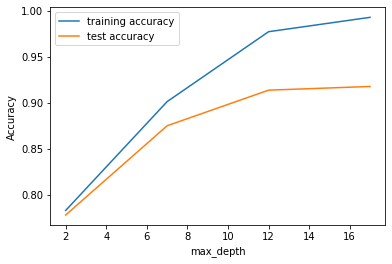

In [106]:
# plotting accuracies with max_depth
plt.figure()
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

#seems 10 to 12

In [107]:
# Tuning n_estimators
# GridSearchCV to find optimal n_estimators
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'n_estimators': range(100, 1500, 400)}

# instantiate the model (note we are specifying a max_depth)
rf = RandomForestClassifier(max_depth=10, class_weight='balanced')


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds,
                   return_train_score= True,
                   scoring="accuracy", n_jobs=-1)
rf.fit(df_train_pca, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=10,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              r

In [108]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,16.029154,0.367332,0.138145,0.001724,100,{'n_estimators': 100},0.901358,0.905170,0.914939,0.908506,...,0.907934,0.004547,4,0.959197,0.959078,0.959376,0.955861,0.958780,0.958458,0.001313
1,81.224515,1.681799,0.650050,0.004097,500,{'n_estimators': 500},0.900405,0.906600,0.916131,0.909936,...,0.908697,0.005155,2,0.959495,0.958304,0.960031,0.957529,0.959435,0.958959,0.000910
2,146.336007,2.631916,1.393562,0.280380,900,{'n_estimators': 900},0.901120,0.908268,0.914701,0.909936,...,0.909126,0.004532,1,0.960150,0.960269,0.960388,0.956755,0.960091,0.959531,0.001392
3,183.262692,17.224582,1.084488,0.163677,1300,{'n_estimators': 1300},0.900167,0.906123,0.915654,0.910889,...,0.908649,0.005206,3,0.959495,0.959018,0.959554,0.957648,0.959793,0.959102,0.000769


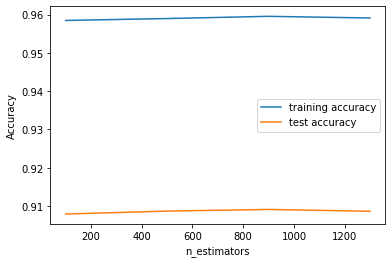

In [109]:
# plotting accuracies with n_estimators
plt.figure()
plt.plot(scores["param_n_estimators"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_n_estimators"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [110]:
# GridSearchCV to find optimal max_features
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_features': [4, 8, 14, 20, 24]}

# instantiate the model
rf = RandomForestClassifier(max_depth=10,class_weight='balanced')


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds,
                   return_train_score= True,
                   scoring="accuracy", n_jobs=-1)
rf.fit(df_train_pca, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=10,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              r

In [111]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,11.171461,0.210942,0.135847,0.004191,4,{'max_features': 4},0.899690,0.904217,0.914224,0.907315,...,0.906457,0.004733,5,0.958959,0.954491,0.957410,0.953479,0.958125,0.956493,0.002130
1,20.870967,0.286745,0.131139,0.007129,8,{'max_features': 8},0.899452,0.904932,0.909697,0.910412,...,0.906886,0.004212,2,0.960091,0.959316,0.958244,0.956755,0.960210,0.958923,0.001291
2,35.119061,0.296112,0.128042,0.006204,14,{'max_features': 14},0.900167,0.904456,0.910412,0.909459,...,0.906934,0.004023,1,0.960567,0.959912,0.958423,0.958363,0.959912,0.959435,0.000884
3,49.241108,0.596741,0.119385,0.014064,20,{'max_features': 20},0.898975,0.905170,0.911127,0.908506,...,0.906886,0.004479,2,0.960567,0.959971,0.961461,0.958006,0.962771,0.960555,0.001586
4,48.784231,6.461530,0.082643,0.016441,24,{'max_features': 24},0.898261,0.905885,0.910412,0.908268,...,0.906838,0.004686,4,0.960686,0.962473,0.961580,0.956814,0.960865,0.960484,0.001940


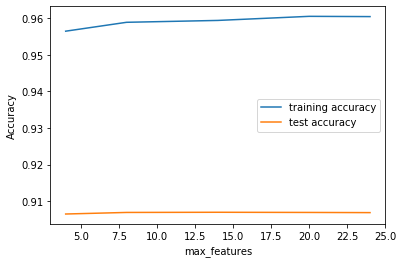

In [112]:
# plotting accuracies with max_features
plt.figure()
plt.plot(scores["param_max_features"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_features"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_features")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# 8 to 10

In [113]:
# GridSearchCV to find optimal min_samples_leaf
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_leaf': range(100, 400, 50)}

# instantiate the model
rf = RandomForestClassifier(class_weight='balanced')


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds,
                   return_train_score= True,
                   scoring="accuracy", n_jobs=-1)
rf.fit(df_train_pca, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                             

In [114]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,12.916213,0.153688,0.127695,0.013644,100,{'min_samples_leaf': 100},0.850846,0.849655,0.858232,0.851561,...,0.853705,0.003746,1,0.871575,0.872647,0.874553,0.871575,0.872051,0.872480,0.001109
1,11.943457,0.141925,0.117653,0.012990,150,{'min_samples_leaf': 150},0.839171,0.839886,0.841792,0.842268,...,0.841506,0.001854,2,0.854539,0.852454,0.854479,0.853943,0.857577,0.854599,0.001668
2,11.113995,0.070625,0.117667,0.006976,200,{'min_samples_leaf': 200},0.830593,0.827496,0.828449,0.830593,...,0.829640,0.001406,3,0.843579,0.847212,0.840064,0.842328,0.844413,0.843519,0.002358
3,10.781236,0.214040,0.118865,0.002486,250,{'min_samples_leaf': 250},0.827734,0.821063,0.825590,0.820110,...,0.824112,0.002981,4,0.840720,0.834286,0.836371,0.831249,0.835299,0.835585,0.003084
4,9.844438,0.726469,0.109163,0.022766,300,{'min_samples_leaf': 300},0.816297,0.815583,0.818442,0.815583,...,0.817584,0.002451,5,0.827734,0.827913,0.828628,0.821658,0.826483,0.826483,0.002509


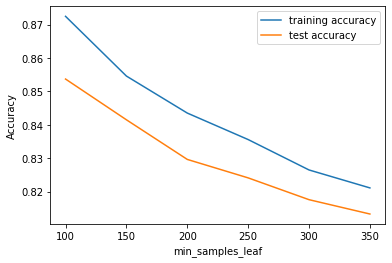

In [115]:
# plotting accuracies with min_samples_leaf
plt.figure()
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

#seems 100 to 150

In [116]:
# GridSearchCV to find optimal min_samples_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_split': range(200, 500, 50)}

# instantiate the model
rf = RandomForestClassifier(class_weight='balanced')


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds,
                   return_train_score=True,
                   scoring="accuracy")
rf.fit(df_train_pca, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                             

In [117]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,6.092148,0.079428,0.054680,0.004262,200,{'min_samples_split': 200},0.872051,0.872766,0.877770,0.877770,...,0.875435,0.002505,1,0.903741,0.899095,0.901239,0.900524,0.903681,0.901656,0.001815
1,5.864191,0.050272,0.052983,0.004950,250,{'min_samples_split': 250},0.863950,0.862283,0.866810,0.864665,...,0.864761,0.001599,2,0.890755,0.888134,0.887479,0.885335,0.892066,0.888754,0.002395
2,5.617488,0.092830,0.048342,0.001508,300,{'min_samples_split': 300},0.855849,0.853228,0.863236,0.860376,...,0.859280,0.004120,3,0.881106,0.880212,0.881999,0.876757,0.884084,0.880832,0.002408
3,5.513868,0.074280,0.046977,0.001671,350,{'min_samples_split': 350},0.850131,0.848225,0.858470,0.857517,...,0.854610,0.004494,4,0.868954,0.872349,0.873779,0.868299,0.872707,0.871218,0.002177
4,5.336101,0.040230,0.046187,0.001251,400,{'min_samples_split': 400},0.843460,0.842745,0.851561,0.847510,...,0.846891,0.003358,5,0.864963,0.865082,0.868835,0.859602,0.865857,0.864868,0.002983


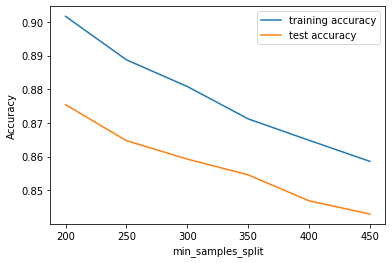

In [118]:
# plotting accuracies with min_samples_split
plt.figure()
plt.plot(scores["param_min_samples_split"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_split"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# 200 to 300

In [119]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [8,10],
    'min_samples_leaf': range(100, 200, 100),
    'min_samples_split': range(200, 400, 100),
    'n_estimators': range(200, 400, 100), 
    'max_features': [8, 10, 12]
}
# Create a based model
rf = RandomForestClassifier(class_weight='balanced')

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,refit='recall_score' ,
                          cv = 5, n_jobs=-1, verbose = 1)

In [120]:
# Fit the grid search to the data
grid_search.fit(df_train_pca, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 14.2min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs...
                                              oob_score=False,
                                              ra

In [121]:
# printing the optimal accuracy score and hyperparameters
print('We can get accuracy of',grid_search.best_score_,'using',grid_search.best_params_)

We can get accuracy of 0.8533238027162259 using {'max_depth': 10, 'max_features': 10, 'min_samples_leaf': 100, 'min_samples_split': 200, 'n_estimators': 300}


In [122]:
# model with the best hyperparameters
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(bootstrap=True, class_weight='balanced',
                             max_depth=10,
                             min_samples_leaf=100, 
                             min_samples_split=200,
                             max_features=8,
                             n_estimators=300)

In [123]:
# fit
rfc.fit(df_train_pca,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=10, max_features=8,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=100, min_samples_split=200,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [124]:
# predict
y_pred_default = rfc.predict(df_test_pca)

In [125]:
print(classification_report(y_test,y_pred_default))
print(confusion_matrix(y_test,y_pred_default))
print('accuracy_score:  ',accuracy_score(y_test,y_pred_default))

              precision    recall  f1-score   support

           0       0.96      0.87      0.92      8179
           1       0.35      0.68      0.46       815

    accuracy                           0.86      8994
   macro avg       0.66      0.78      0.69      8994
weighted avg       0.91      0.86      0.88      8994

[[7150 1029]
 [ 262  553]]
accuracy_score:   0.8564598621303091


In [126]:
# Confusion Matrix
confusion_rf_hyper=confusion_matrix(y_test,y_pred_default)
confusion_rf_hyper

array([[7150, 1029],
       [ 262,  553]], dtype=int64)

In [127]:
TN = confusion_rf_hyper[0,0] # true positive 
TP = confusion_rf_hyper[1,1] # true negatives
FP = confusion_rf_hyper[0,1] # false positives
FN = confusion_rf_hyper[1,0] # false negatives

print('Accuracy Score:  ',accuracy_score(y_test,y_pred_default))

# Let's see the sensitivity of our logistic regression model
print('Sensitivity: ', TP / float(TP+FN))

# Let us calculate specificity
print('Specificity: ',TN / float(TN+FP))

# Calculate false postive rate - predicting churn when customer does not have churned
print('false postive rate: ',FP/ float(TN+FP))

# positive predictive value 
print('positive predictive value: ', TP / float(TP+FP))

# Negative predictive value
print('Negative predictive value: ',TN / float(TN+ FN))

## Misclassification rate

print('Misclassification Rate: ',(FN+FP)/(TP+TN+FP+FN))

Accuracy Score:   0.8564598621303091
Sensitivity:  0.6785276073619632
Specificity:  0.8741899987773566
false postive rate:  0.12581000122264335
positive predictive value:  0.3495575221238938
Negative predictive value:  0.9646519158121964
Misclassification Rate:  0.14354013786969091


### Recomendation for Model Selection
- Logistic Regression and Random Forest performed better than Decision Tree for customer churn analysis for this particular dataset, using PCA.
- LogisticRegression is the best model 80.9% Sensitivity
- Accuracy of RandomForest is highest with 85%

#### LogisticRegression 
- Accuracy Score : 0.8110962864131643 (With PCA on Test)
- Sensitivity: 0.8098159509202454 (with PCA)

- Accuracy Score : 0.811985768289971 (With RFE on Test)
- Sensitivity: 0.8122699386503067 (with RFE)

#### RandomForest
- Accuracy Score:   0.8570157883033134
- Sensitivity:  0.6711656441717792

#### DecisionTree
- Sensitivity:  0.6233128834355828 (with PCA)

### RandomForest on all feature

In [128]:
# Importing random forest classifier from sklearn library
from sklearn.ensemble import RandomForestClassifier

# Running the random forest with default parameters.
rfc = RandomForestClassifier(class_weight='balanced')

In [129]:
# fit
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [130]:
# Making predictions
predictions = rfc.predict(X_test)

In [131]:
# Importing classification report and confusion matrix from sklearn metrics
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score

print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))
print(accuracy_score(y_test,predictions))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97      8179
           1       0.78      0.40      0.53       815

    accuracy                           0.94      8994
   macro avg       0.86      0.70      0.75      8994
weighted avg       0.93      0.94      0.93      8994

[[8087   92]
 [ 485  330]]
0.9358461196353124


In [132]:
# Confusion Matrix
confusion_rf_with_all_feature=confusion_matrix(y_test,predictions)
confusion_rf_with_all_feature

array([[8087,   92],
       [ 485,  330]], dtype=int64)

In [133]:
TN = confusion_rf_with_all_feature[0,0] # true positive 
TP = confusion_rf_with_all_feature[1,1] # true negatives
FP = confusion_rf_with_all_feature[0,1] # false positives
FN = confusion_rf_with_all_feature[1,0] # false negatives

print('Accuracy Score: ', accuracy_score(y_test,predictions))
# Let's see the sensitivity of our logistic regression model
print('Sensitivity: ', TP / float(TP+FN))

# Let us calculate specificity
print('Specificity: ',TN / float(TN+FP))

# Calculate false postive rate - predicting churn when customer does not have churned
print('false postive rate: ',FP/ float(TN+FP))

# positive predictive value 
print('positive predictive value: ', TP / float(TP+FP))

# Negative predictive value
print('Negative predictive value: ',TN / float(TN+ FN))

## Misclassification rate

print('Misclassification Rate: ',(FN+FP)/(TP+TN+FP+FN))

Accuracy Score:  0.9358461196353124
Sensitivity:  0.4049079754601227
Specificity:  0.988751681134613
false postive rate:  0.011248318865386967
positive predictive value:  0.7819905213270142
Negative predictive value:  0.9434204386374242
Misclassification Rate:  0.06415388036468757


### Hyperparameter Tuning 

In [134]:
# GridSearchCV to find optimal n_estimators
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(2, 20, 5)}

# instantiate the model
rf = RandomForestClassifier(class_weight='balanced')


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds,
                    return_train_score=True,
                   scoring="accuracy", n_jobs=-1)


In [135]:
rf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                             

In [136]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,2.366229,0.034082,0.075446,0.001320,2,{'max_depth': 2},0.873005,0.879199,0.888492,0.876102,...,0.882392,0.008224,4,0.881344,0.885156,0.887717,0.874017,0.893198,0.884286,0.006420
1,6.804576,0.091012,0.115935,0.005467,7,{'max_depth': 7},0.902788,0.909936,0.917560,0.914939,...,0.911746,0.005112,3,0.927091,0.926495,0.922742,0.920658,0.924946,0.924386,0.002395
2,9.734314,0.174818,0.154878,0.012176,12,{'max_depth': 12},0.925185,0.929473,0.939957,0.935907,...,0.932761,0.005102,2,0.970693,0.971646,0.969621,0.969204,0.971587,0.970550,0.000997
3,9.199610,1.014991,0.097094,0.016358,17,{'max_depth': 17},0.931856,0.932333,0.941625,0.942340,...,0.936717,0.004477,1,0.987431,0.989218,0.986836,0.986181,0.987015,0.987336,0.001024


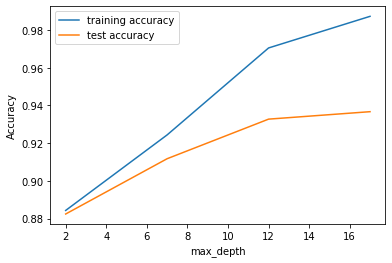

In [137]:
# plotting accuracies with max_depth
plt.figure()
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

#10,12

In [138]:
# GridSearchCV to find optimal n_estimators
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'n_estimators': range(100, 1000, 400)}

# instantiate the model (note we are specifying a max_depth)
rf = RandomForestClassifier(max_depth=10, class_weight='balanced')


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds,
                   return_train_score=True,
                   scoring="accuracy", n_jobs=-1)
rf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=10,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              r

In [139]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,9.970193,0.217920,0.173120,0.003324,100,{'n_estimators': 100},0.917798,0.924470,0.933762,0.930903,...,0.926995,0.005534,3,0.956695,0.957172,0.954193,0.953717,0.955147,0.955385,0.001354
1,50.705959,0.633557,0.745050,0.115288,500,{'n_estimators': 500},0.922087,0.925185,0.934954,0.932094,...,0.928568,0.004619,1,0.958542,0.958482,0.956993,0.955980,0.956874,0.957374,0.000993
2,67.920615,11.632005,0.794072,0.169808,900,{'n_estimators': 900},0.918513,0.925423,0.934954,0.932809,...,0.927901,0.005798,2,0.958125,0.957708,0.957648,0.956219,0.958065,0.957553,0.000693


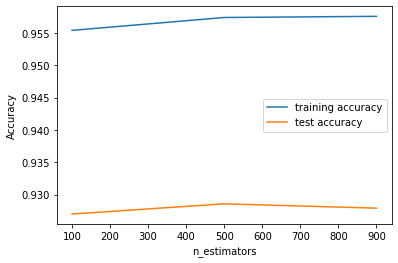

In [140]:
# plotting accuracies with n_estimators
plt.figure()
plt.plot(scores["param_n_estimators"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_n_estimators"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [141]:
# GridSearchCV to find optimal max_features
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_features': [4, 8, 14, 20, 24]}

# instantiate the model
rf = RandomForestClassifier(max_depth=10, class_weight='balanced')


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds,
                   return_train_score= True,
                   scoring="accuracy")
rf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=10,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              r

In [142]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.897186,0.032463,0.051614,0.002064,4,{'max_features': 4},0.916845,0.919705,0.930188,0.928520,...,0.923803,0.005064,5,0.950024,0.949071,0.948475,0.947343,0.951453,0.949273,0.001394
1,3.369998,0.053499,0.049970,0.000349,8,{'max_features': 8},0.920181,0.923517,0.932571,0.931618,...,0.927377,0.004781,2,0.956219,0.956695,0.956219,0.956338,0.957529,0.956600,0.000496
2,5.648654,0.129114,0.048374,0.003515,14,{'max_features': 14},0.919943,0.922564,0.934477,0.932333,...,0.927901,0.005656,1,0.959316,0.958721,0.957827,0.956814,0.958065,0.958149,0.000846
3,7.816322,0.055115,0.050115,0.006520,20,{'max_features': 20},0.919228,0.921134,0.931618,0.931618,...,0.926376,0.005238,3,0.960627,0.961163,0.960031,0.958840,0.959376,0.960007,0.000834
4,9.215789,0.086513,0.047601,0.001895,24,{'max_features': 24},0.919466,0.920419,0.933762,0.928520,...,0.926185,0.005438,4,0.960686,0.960091,0.959614,0.957946,0.958959,0.959459,0.000945


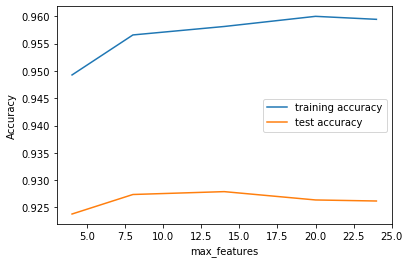

In [143]:
# plotting accuracies with max_features
plt.figure()
plt.plot(scores["param_max_features"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_features"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_features")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [144]:
# GridSearchCV to find optimal min_samples_leaf
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_leaf': range(100, 400, 50)}

# instantiate the model
rf = RandomForestClassifier(class_weight='balanced')


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds,
                   return_train_score= True,
                   scoring="accuracy")
rf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                             

In [145]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,2.892985,0.073874,0.048211,0.003277,100,{'min_samples_leaf': 100},0.884680,0.882535,0.890160,0.892066,...,0.888063,0.003750,1,0.898142,0.894687,0.893734,0.892542,0.892066,0.894234,0.002158
1,2.659637,0.049886,0.044473,0.003162,150,{'min_samples_leaf': 150},0.877532,0.874911,0.882297,0.883012,...,0.881010,0.004348,2,0.891470,0.886467,0.886467,0.885156,0.886467,0.887205,0.002192
2,2.456088,0.037485,0.041554,0.000331,200,{'min_samples_leaf': 200},0.878723,0.875864,0.871098,0.884680,...,0.879247,0.005505,3,0.886943,0.885156,0.875208,0.885573,0.882833,0.883143,0.004182
3,2.315195,0.037228,0.041659,0.000299,250,{'min_samples_leaf': 250},0.875149,0.875625,0.877532,0.877293,...,0.878199,0.003714,4,0.884322,0.882595,0.879676,0.881403,0.883429,0.882285,0.001621
4,2.221950,0.054657,0.040871,0.001733,300,{'min_samples_leaf': 300},0.876340,0.874911,0.874672,0.876579,...,0.876817,0.002499,5,0.882356,0.881701,0.879080,0.878485,0.874375,0.879199,0.002829


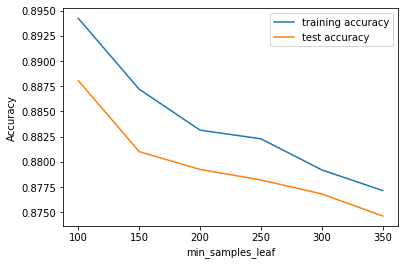

In [146]:
# plotting accuracies with min_samples_leaf
plt.figure()
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [147]:
# GridSearchCV to find optimal min_samples_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_split': range(100, 700, 50)}

# instantiate the model
rf = RandomForestClassifier(class_weight='balanced')


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds,
                   return_train_score= True,
                   scoring="accuracy")
rf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                             

In [148]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,3.767478,0.051374,0.055867,0.005638,100,{'min_samples_split': 100},0.905647,0.909936,0.919943,0.919466,...,0.914129,0.005552,1,0.935371,0.936026,0.934656,0.933107,0.934477,0.934727,0.000979
1,3.649921,0.049351,0.056663,0.007151,150,{'min_samples_split': 150},0.900167,0.899929,0.906600,0.912795,...,0.905885,0.005154,2,0.925304,0.921849,0.918275,0.919764,0.922683,0.921575,0.002424
2,3.561254,0.048989,0.047779,0.001930,200,{'min_samples_split': 200},0.891827,0.894210,0.904932,0.905170,...,0.899786,0.005638,3,0.915178,0.913807,0.908327,0.909400,0.912735,0.911889,0.002611
3,3.431575,0.064335,0.047786,0.001841,250,{'min_samples_split': 250},0.889683,0.886824,0.899214,0.902073,...,0.895592,0.006129,4,0.909995,0.902609,0.902669,0.908387,0.905885,0.905909,0.002974
4,3.324237,0.053866,0.048352,0.003243,300,{'min_samples_split': 300},0.885156,0.885633,0.898022,0.891827,...,0.891208,0.005140,5,0.901060,0.901835,0.899273,0.896772,0.901358,0.900060,0.001858


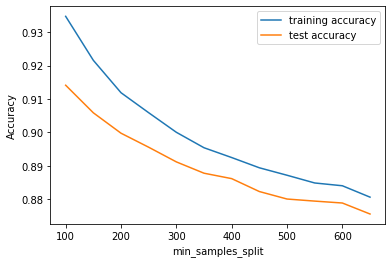

In [149]:
# plotting accuracies with min_samples_split
plt.figure()
plt.plot(scores["param_min_samples_split"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_split"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [150]:
# model with the best hyperparameters
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [10,12],
    'min_samples_leaf': range(150, 250, 50),
    'min_samples_split': range(200, 400, 100),
    'n_estimators': [300,400,500], 
    'max_features': [15, 20]
}
# Create a based model
rf = RandomForestClassifier(class_weight='balanced')
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,refit='recall_score' ,
                          cv = 3, verbose = 1, n_jobs=-1)

In [151]:
# fit
grid_search.fit(X_train,y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed: 12.7min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                             

- printing the optimal accuracy score and hyperparameters

In [152]:
# printing the optimal accuracy score and hyperparameters
print('We can get accuracy of',grid_search.best_score_,'using',grid_search.best_params_)

We can get accuracy of 0.8750059566356921 using {'max_depth': 12, 'max_features': 15, 'min_samples_leaf': 150, 'min_samples_split': 200, 'n_estimators': 500}


In [153]:
# model with the best hyperparameters
from sklearn.ensemble import RandomForestClassifier
rfc_final = RandomForestClassifier(bootstrap=True,class_weight='balanced',
                             max_depth=10,
                             min_samples_leaf=150, 
                             min_samples_split=300,
                             max_features=15,
                             n_estimators=500)

In [154]:
# fit
rfc_final.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=10, max_features=15,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=150, min_samples_split=300,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [155]:
# predict
predictions = rfc_final.predict(X_test)

In [156]:
from sklearn import metrics
confusion_rm_f = metrics.confusion_matrix( y_test, predictions )
confusion_rm_f

array([[7156, 1023],
       [ 139,  676]], dtype=int64)

In [157]:
TN = confusion_rm_f[0,0] # true positive 
TP = confusion_rm_f[1,1] # true negatives
FP = confusion_rm_f[0,1] # false positives
FN = confusion_rm_f[1,0] # false negatives

print('Accuracy Score: ',accuracy_score(y_test,predictions))
# Let's see the sensitivity of our logistic regression model
print('Sensitivity: ', TP / float(TP+FN))

# Let us calculate specificity
print('Specificity: ',TN / float(TN+FP))

# Calculate false postive rate - predicting churn when customer does not have churned
print('false postive rate: ',FP/ float(TN+FP))

# positive predictive value 
print('positive predictive value: ', TP / float(TP+FP))

# Negative predictive value
print('Negative predictive value: ',TN / float(TN+ FN))

## Misclassification rate

print('Misclassification Rate: ',(FN+FP)/(TP+TN+FP+FN))

Accuracy Score:  0.8708027573938181
Sensitivity:  0.8294478527607362
Specificity:  0.8749235847903166
false postive rate:  0.12507641520968332
positive predictive value:  0.39788110653325487
Negative predictive value:  0.9809458533241947
Misclassification Rate:  0.1291972426061819


### RandomForest model with All feature gives: 
- **87%** of Accuracy and **82.9%** of Sensitivity

In [158]:
#Important Variables
from collections import OrderedDict
feature_names=list(X_train.columns.values)
important_features_dict = {}
for name, importance in zip(feature_names, rfc_final.feature_importances_):
    important_features_dict[name]=importance
#Sorting Dictionary in descending order of the importance variable
d_descending = OrderedDict(sorted(important_features_dict.items(), 
                                  key=lambda kv: kv[1], reverse=True))

In [159]:
telecom_df5.columns

Index(['mobile_number', 'arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6',
       'offnet_mou_6', 'offnet_mou_7', 'roam_ic_mou_6', 'roam_ic_mou_7',
       'roam_ic_mou_8', 'loc_og_t2t_mou_6', 'loc_og_t2m_mou_6',
       'loc_og_t2f_mou_6', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7',
       'loc_og_t2c_mou_8', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7',
       'std_og_t2f_mou_8', 'isd_og_mou_6', 'spl_og_mou_6', 'spl_og_mou_7',
       'spl_og_mou_8', 'og_others_6', 'loc_ic_t2t_mou_6', 'loc_ic_t2m_mou_6',
       'loc_ic_t2f_mou_6', 'std_ic_t2t_mou_6', 'std_ic_t2t_mou_7',
       'std_ic_t2m_mou_6', 'std_ic_t2f_mou_6', 'std_ic_t2f_mou_7',
       'std_ic_t2f_mou_8', 'isd_ic_mou_6', 'ic_others_6', 'ic_others_7',
       'ic_others_8', 'total_rech_num_6', 'total_rech_num_7', 'max_rech_amt_6',
       'max_rech_amt_7', 'max_rech_amt_8', 'date_of_last_rech_6',
       'date_of_last_rech_7', 'date_of_last_rech_8', 'last_day_rch_amt_6',
       'last_day_rch_amt_7', 'last_day_rch_amt_8', 'monthly_2g_6',
       'mont

In [160]:
#Variable Importance top 30 variable
dic= dict(d_descending)

from itertools import islice

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

n=12
n_items = take(n, dic.items())

In [161]:
print('These are top 12 driver variable: ',n_items)

These are top 12 driver variable:  [('arpu_8', 0.2561583859840162), ('last_day_rch_amt_8', 0.19706938195467769), ('roam_ic_mou_8', 0.1347911467174134), ('max_rech_amt_8', 0.1141804909191033), ('date_of_last_rech_8', 0.07992630948168873), ('spl_og_mou_8', 0.03265324140085262), ('std_ic_t2f_mou_8', 0.018875958916965144), ('loc_og_t2f_mou_6', 0.012207586928584101), ('roam_ic_mou_7', 0.012195900253861951), ('loc_ic_t2f_mou_6', 0.012124434548279934), ('arpu_7', 0.011133455347377766), ('ic_others_8', 0.009828200704631617)]


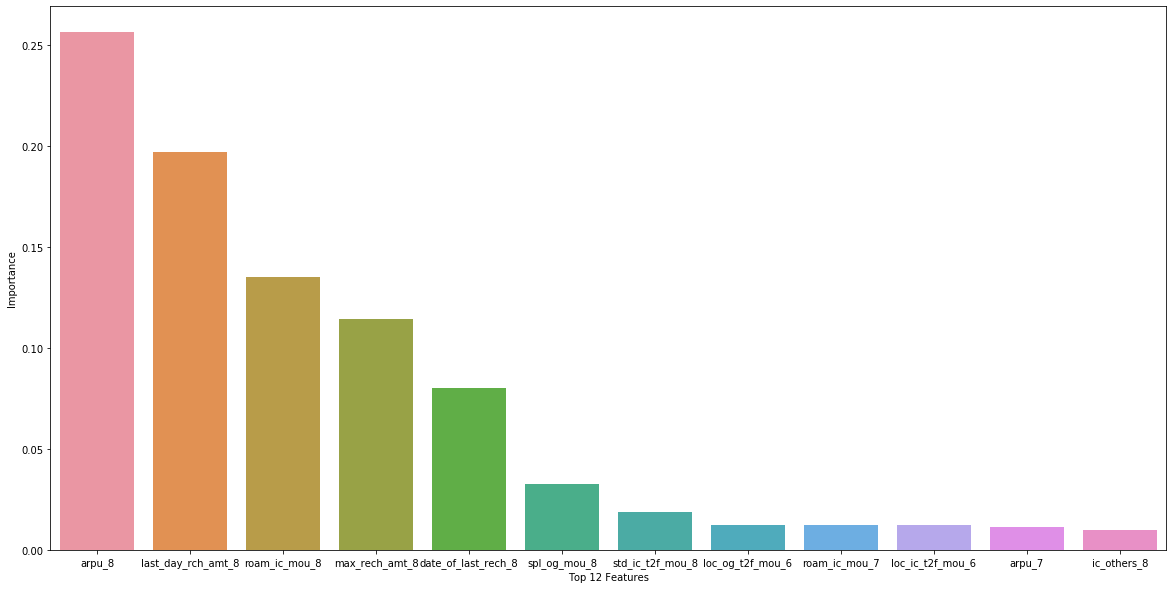

In [162]:
imp=rfc_final.feature_importances_
names=X_train.columns.values
imp,names=zip(*sorted(zip(imp,names)))

df_1=pd.DataFrame({"Variable":names,"importance":imp})
df_2 = df_1.sort_values(by="importance",axis=0,ascending=False)
df_2 = df_2.reset_index(drop=True)


plt.figure(figsize=(20, 10))

ax = sns.barplot(x='Variable', y= 'importance', data=df_2[0:12])
ax.set(xlabel = 'Top 12 Features', ylabel = 'Importance')
plt.show()

C:\Users\hp\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


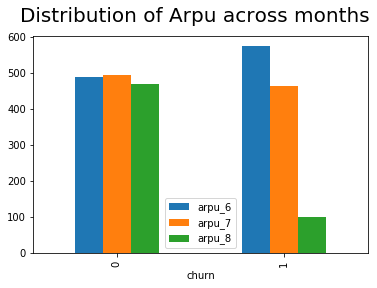

C:\Users\hp\anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  import sys


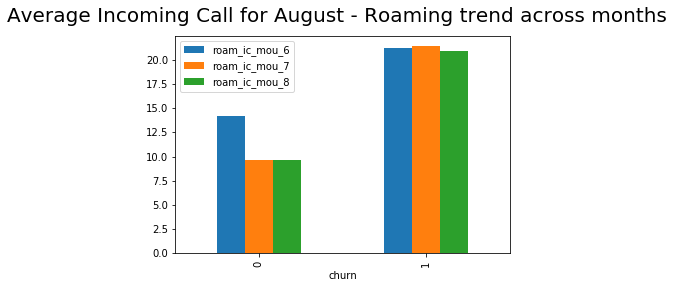

C:\Users\hp\anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  if sys.path[0] == '':


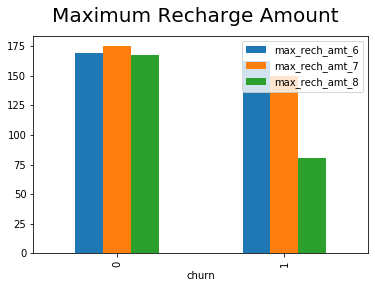

C:\Users\hp\anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


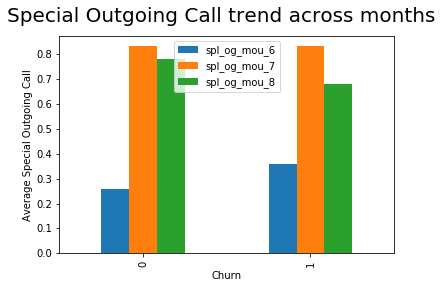

C:\Users\hp\anaconda3\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


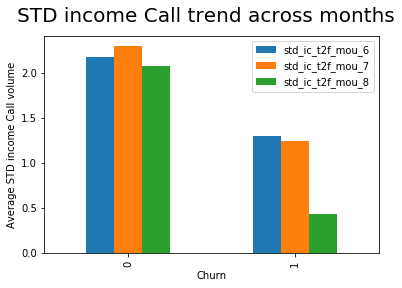

C:\Users\hp\anaconda3\lib\site-packages\ipykernel_launcher.py:34: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


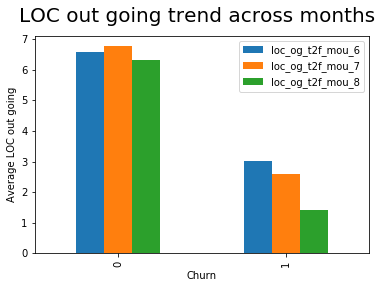

C:\Users\hp\anaconda3\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


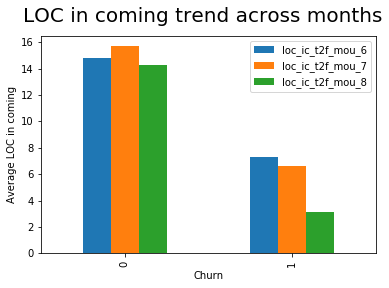

C:\Users\hp\anaconda3\lib\site-packages\ipykernel_launcher.py:48: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


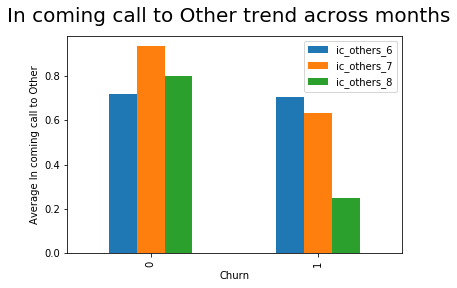

C:\Users\hp\anaconda3\lib\site-packages\ipykernel_launcher.py:56: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


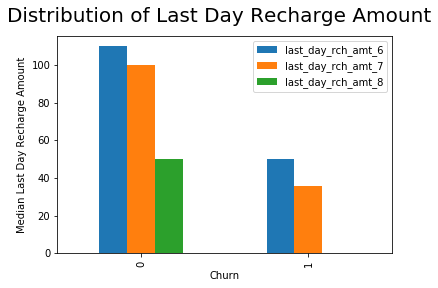

In [163]:
telecom_df2['churn'] = telecom_df2['churn'].astype('object', copy = False)
df_sample = telecom_df2.groupby(['churn'])['arpu_6', 'arpu_7', 'arpu_8'].median()
df_sample.plot.bar()
plt.suptitle('Distribution of Arpu across months', fontsize=20)
plt.show()

df_sample = telecom_df2.groupby(['churn'])['roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8'].mean()
df_sample.plot.bar()
plt.suptitle('Average Incoming Call for August - Roaming trend across months', fontsize=20)
plt.show()

df_sample = telecom_df2.groupby(['churn'])['max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8'].mean()
df_sample.plot.bar()
plt.suptitle('Maximum Recharge Amount', fontsize=20)
plt.show()


df_sample = telecom_df2.groupby(['churn'])['spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8'].median()
df_sample.plot.bar()
plt.suptitle('Special Outgoing Call trend across months', fontsize=20)
plt.xlabel("Churn")
plt.ylabel("Average Special Outgoing Call")
plt.show()


df_sample = telecom_df2.groupby(['churn'])['std_ic_t2f_mou_6', 'std_ic_t2f_mou_7', 'std_ic_t2f_mou_8'].mean()
df_sample.plot.bar()
plt.suptitle('STD income Call trend across months', fontsize=20)
plt.xlabel("Churn")
plt.ylabel("Average STD income Call volume")
plt.show()


df_sample = telecom_df2.groupby(['churn'])['loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8'].mean()
df_sample.plot.bar()
plt.suptitle('LOC out going trend across months', fontsize=20)
plt.xlabel("Churn")
plt.ylabel("Average LOC out going")
plt.show()

df_sample = telecom_df2.groupby(['churn'])['loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_7', 'loc_ic_t2f_mou_8'].mean()
df_sample.plot.bar()
plt.suptitle('LOC in coming trend across months', fontsize=20)
plt.xlabel("Churn")
plt.ylabel("Average LOC in coming")
plt.show()

df_sample = telecom_df2.groupby(['churn'])['ic_others_6', 'ic_others_7', 'ic_others_8'].mean()
df_sample.plot.bar()
plt.suptitle('In coming call to Other trend across months', fontsize=20)
plt.xlabel("Churn")
plt.ylabel("Average In coming call to Other")
plt.show()

telecom_df2['churn'] = telecom_df2['churn'].astype('object', copy = False)
df_sample = telecom_df2.groupby(['churn'])['last_day_rch_amt_6', 'last_day_rch_amt_7', 'last_day_rch_amt_8'].median()
df_sample.plot.bar()
plt.suptitle('Distribution of Last Day Recharge Amount', fontsize=20)
plt.xlabel("Churn")
plt.ylabel("Median Last Day Recharge Amount")
plt.show()

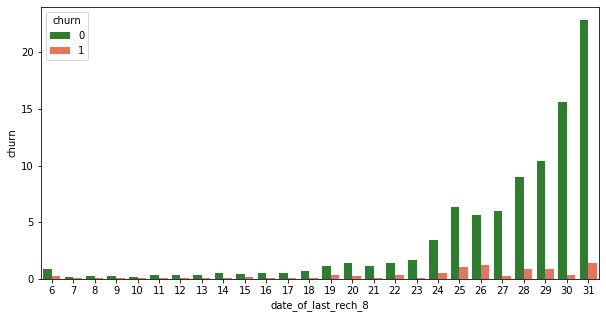

In [164]:

plt.figure(figsize=(10,5))
palette = ["#228B22", "#FF6347"]
sns.barplot(x="date_of_last_rech_8", y="churn", hue="churn", data=telecom_df4, palette=palette, 
            estimator=lambda x: len(x) / len(telecom_df4) * 100)

### Different Models created

- 1. LogisticRegression with PCA
- 2. Logistic Regression without PCA (Using RFE)
- 3. DecisionTree (with PCA)
- 4. Random Forest (with PCA)
- 5. Random Forest with all features

#### Logistic Regression with PCA
- Accuracy Score on test data:  0.8112074716477652
- Sensitivity:  0.8098159509202454
- Specificity:  0.8057219709010881
- false postive rate:  0.19427802909891184
- positive predictive value:  0.2934637616718542
- Negative predictive value:  0.9770200148257969
- Misclassification Rate:  0.1939070491438737


#### Logistic Regression with RFE
- Accuracy Score :  0.8117633978207695
- Sensitivity:  0.811042944785276
- Specificity:  0.8048661205526348
- false postive rate:  0.1951338794473652
- positive predictive value:  0.2928666371289322
- Negative predictive value:  0.9771411607540448

#### LogisticRegression 
- Accuracy Score : 0.8110962864131643 (With PCA on Test)
- Sensitivity: 0.8098159509202454 (with PCA)

- Accuracy Score : 0.811985768289971 (With RFE on Test)
- Sensitivity: 0.8122699386503067 (with RFE)

#### RandomForest
- Accuracy Score:   0.8570157883033134
- Sensitivity:  0.6711656441717792

#### DecisionTree
- Sensitivity:  0.6233128834355828 (with PCA)

### RandomForest model with All feature gives:
- **87%** of Accuracy and **82.9%** of Sensitivity

### Driver variables of Churn and strategies to manage customer churn & Recommendation

- std_ic_t2f_mou_8 - Lower the STD incoming call, higher is the churn rate. Focus on customers whose STD incoming call amount has decreased for that month.

- ARPU 7th and 8th - Average Revenue Per User decreases from 6th to 7th month to 8th month as most of the users are churned by 8th month.

- date_of_last_rech_8 - Most of the Users are churned between 25th to 31st of the month. Hence providing offers prior to 25th can reduce the churn. Send out periodic offers to customers between 15th of the month to 25th of the month.

- max_rech_amt_8- Focus on the customer whoes Avg max recharge amount has been decreased

- last_day_rch_amt_8 - Lower the last day recharge amount higher the churn rate. Focus on customers whose last day recharge amount has decrased. Specialy for customers without any recharge amount.

- roam_ic_mou_8 - Higher the incoming roaming amount, higher is the churn rate. Focus on customers whose incoming roaming amount has increased, because they are likely to churn.
